# Este cuaderno computa efectos marginales por variaciones en características

In [4]:
## Librerias necesarias
import pycaret
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
import tensorflow as tf

import os
import socket
import joblib
import warnings
import numpy as np
import pandas as pd
from scipy.stats import sem
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Configuración de rutas
if socket.gethostname()=='SRVCBECO01':
    os.chdir('D:\shared_data\Dropbox\Vías clinicas diabetes')
elif socket.gethostname() == 'HPJP2': 
    os.chdir(r'C:\Users\juanm\Dropbox\JP_files\UR\Vías clinicas diabetes')
elif socket.gethostname() == 'CNF106054': 
    os.chdir(r'C:\Users\paul.rodriguez\Dropbox\Salud Colombia\Diabetes Sanitas\Vías clinicas diabetes')
elif socket.gethostname() == 'CNF77701': 
    os.chdir(r'C:\Users\juanpablo.martinez\Dropbox\Vías clinicas diabetes')

    
raw_path = 'Datos org\\csv_rutas\\'
created_path = "Datos creados\\"
temp_path = 'temporales\\'
dbs_path = "Datos creados\\ml_databases\\4_cat\\"


print('Directorio actual: '+ os.getcwd())

Directorio actual: C:\Users\juanm\Dropbox\JP_files\UR\Vías clinicas diabetes


## Funciones - Otros modelos

#### Identifcando variables categóricas y numéricas en la base de datos

In [5]:
def cat_num_identify(ml_data, rename_df):
    categorical_vars_master = ['femenino', 'ERC_high', 'ERC1', 'ERC2', 'adhiere_guia', 'no_adhiere', 'adhiere_colesterol', 'analgesicos',
                                   'antiacidos', 'antihipertensivos', 'hipoglicemiantes', 'hipolipemiantes', 'nutrition_tag_max', 
                                   'exercise_tag_max', 'alcohol_tag_max', 'tobaco_tag_max', 'creatinina_missing']

    categorical_vars = list(set(ml_data.columns).intersection(categorical_vars_master))

    numerical_vars = set(ml_data.columns).difference(set(categorical_vars+['KeyAnonimo', 'year', 'base_label', 'comorbilidades', 'fuera_metas', 'tgt_label']))
    numerical_vars = list(numerical_vars)

    types_df = pd.DataFrame({'old_name' : categorical_vars+numerical_vars,
                             'type' : ['categorical']*len(categorical_vars)+['numerical']*len(numerical_vars)})

    types_df = types_df.merge(rename_df, on = 'old_name', how = 'inner')

    new_cat_vars = list(types_df.loc[types_df['type'] == 'categorical', 'new_name'].values)
    new_num_vars = list(types_df.loc[types_df['type'] == 'numerical', 'new_name'].values)
    
    return new_cat_vars, new_num_vars

#### Partición entre variables exógenas y endógenas

In [6]:
def endog_exog_select(data_mat, dep_var):
    X = data_mat.drop(dep_var, axis = 1)
    Y = data_mat.loc[:, dep_var]
    return(X, Y)

#### Preparación de las bases de entrenamiento y validación

In [7]:
## Función para cargar y eliminar variables no deseadas
def data_clean(df_path, dep_var):
    
    ## Listado de variables a eliminar 
    vars_to_drop = ['KeyAnonimo', 'year', 'base_label', 'tgt_label']
    if dep_var == "comorbilidades":
        vars_to_drop = vars_to_drop+['fuera_metas']
    elif dep_var == "fuera_metas":
        vars_to_drop = vars_to_drop+['comorbilidades']
    
    ## Cargando la base de datos
    data_mat = pd.read_csv(df_path)
    
    ## Eliminando variables innecesarias
    data_mat.drop(vars_to_drop, axis = 1, inplace = True)
    
    return(data_mat.reset_index(drop = True))

def data_prepare_wrapper(tgt_year, base_label, dep_var, model_type):
    ## Construyendo los paths de entrenamiento y validación
    train_path = dbs_path+"train\\train_db_{}_years_base_{}.csv".format(tgt_year, base_label)
    vali_path = dbs_path+"vali\\vali_db_{}_years_base_{}.csv".format(tgt_year, base_label)

    ## Diccionario para renombrar variables
    rename_dict ={'femenino' : 'Female', 'edad' : 'Age (Years)', 'peso': 'Weight (Kg)', 'talla' : 'Height (m)', 
                  'imc' : "BMI (kg/m*m)", 'Colesterol_LDL' : 'LDL Chol. (mg/dL)', 'TFG' : "eGFR (mg/g)", 
                  "ta_diastolica" : "Diast. B.P. (mmHg)", 'ta_sistolica' : 'Sist. B.P. (mmHg)', 'adhiere_guia' : "Hba1c guide Adh.", 
                  "no_adhiere" : "Pharma. Adh.", "analgesicos" : "Analgesics", "antiacidos" : "Antacdis",
                  "antihipertensivos" : "Antihypertensive", "hipoglicemiantes" : "Hypoglecimic agents", 
                  "hipolipemiantes" : "Lipid-lowering agents", "nutrition_tag_max" : "Nutrition recomm.", 
                  "exercise_tag_max" : "Physical act. recomm.", "alcohol_tag_max" : "Alcohol recomm.",
                  "tobaco_tag_max" : "Tobacco recomm.", "creatinina" : "Creatinine (mg/dL)", 
                  "adhiere_colesterol" : "Chol. Adh."} 

    rename_df = pd.DataFrame(rename_dict, index = rename_dict.keys())
    rename_df = pd.DataFrame({'old_name' : rename_df.index, 'new_name' : np.diag(rename_df)})
    
    ## Preparando los datos
    train = data_clean(df_path = train_path, dep_var = dep_var)
    vali = data_clean(df_path = vali_path, dep_var = dep_var)

    ## Identificando variables categóricas y numéricas presentes
    cat_vars, num_vars = cat_num_identify(ml_data = train, rename_df = rename_df)

    ## Renombrando las variables para el gráfico
    train.rename(rename_dict, axis = 1, inplace = True)
    vali.rename(rename_dict, axis = 1, inplace = True)
    
    if model_type != "nn":
        return train, vali, cat_vars, num_vars
    
    elif model_type == "nn":
        ## Segmentación entre variables endógenas y exógenas 
        X_train, Y_train = endog_exog_select(data_mat = train,
                                                 dep_var = 'fuera_metas')
                                                 #dep_var = 'comorbilidades')
        X_vali, Y_vali = endog_exog_select(data_mat = vali, 
                                           dep_var = 'fuera_metas')
                                        #   dep_var = 'comorbilidades')

        return X_train, Y_train, X_vali, Y_vali, cat_vars, num_vars

#### Efectos marginales de la red neuronal

In [8]:
def nn_margeff_compute(model_name, model_type, tgt_year, base_label, dep_var):
    ## Cargando el modelo a partir del nombre 
    trained_model = tf.keras.models.load_model(created_path+"ml_models\\final\\{}.keras".format(model_name))

    ## Organizando los datos para predecir
    X_train, Y_train, X_vali, Y_vali, cat_vars, num_vars = data_prepare_wrapper(tgt_year = tgt_year, base_label = base_label, dep_var = dep_var, model_type = model_type)

    ## Iterando entre las columnas para hallar los efectos marginales
    tgt_vars = X_vali.columns
    #tgt_vars = ['Alcohol recomm.', 'Chol. Adh.', "eGFR (mg/g)", 'Hba1c guide Adh.', 'Hypoglecimic agents', 
    #            'Nutrition recomm.', 'Pharma. Adh.', 'Physical act. recomm.', 'Tobacco recomm.']
    coefficients = []

    for var in tgt_vars:
        # Prediciendo para los datos originales
        org_prs = trained_model.predict(X_vali, verbose  = 0)
        
        # Copiando los datos de validación
        new_vali = X_vali

        # Modificando la variable dependiendo de si es numérica o categórica
        if var in num_vars:
            new_vali[var] = new_vali[var]+1
        elif var in cat_vars:
            new_vali[var] = np.where(new_vali[var] == 0, 1, 1)

        # Prediciendo para la variación
        new_prs = trained_model.predict(new_vali, verbose  = 0)
        
        prs_dif = new_prs-org_prs

        coefficients.append(pd.DataFrame({'model_name' : [model_name], 
                                          'Dependent variable': [dep_var], 
                                          'base_label': [base_label], 
                                          "Time Horizon" : [tgt_year], 
                                          "Model type" : ['NeuralNetwork'],
                                          'Variable' : [var],
                                          'pctg' : [100*np.mean(prs_dif)], 
                                          'p5' : 100*np.percentile(prs_dif, 5), 
                                          'p95' : 100*np.percentile(prs_dif, 95), 
                                          "std" : 100*np.std(prs_dif), 
                                          'n' : len(prs_dif)}))

    return pd.concat(coefficients, axis = 0)

#### Efectos marginales del resto de modelos

In [9]:
## Cargando el modelo a partir del nombre 
def other_margeff_compute(model_name, model_type, tgt_year, base_label, dep_var):
    trained_model = model_loader(model_name  = model_name)
    model_type = str(type(trained_model[6])).split(".")[-1:][0].split("'")[0]

    ## Organizando los datos para predecir
    train, vali, cat_vars, num_vars = data_prepare_wrapper(tgt_year = tgt_year, 
                                                          base_label = base_label,
                                                          dep_var = dep_var,
                                                          model_type = model_type)
    
    ## Pycaret setup
    s = setup(data = train,
              target = dep_var,
              test_data = vali,
              session_id = 123,
              index = False,
              numeric_features = num_vars,
              categorical_features = cat_vars,
              remove_multicollinearity = True,
              fix_imbalance = False,
               #feature_selection = False,
              feature_selection = True,
              feature_selection_method = "sequential",
              n_features_to_select = 0.5,
              use_gpu = False, 
             verbose = 0)

    ## Predicción para cada columna 
    coefficients = []
    tgt_vars = vali.drop(dep_var, axis = 1).columns
    for var in tgt_vars:
        
        org_prs = predict_model(trained_model[6], data = vali,
                        raw_score = True,
                        verbose = 0)["prediction_score_1"]
        
        # Modificando la variable dependiendo de si es numérica o categórica
        new_vali = vali 
        if var in num_vars:
            new_vali[var] = new_vali[var]+1
        elif var in cat_vars:
            new_vali[var] = np.where(new_vali[var] == 0, 1, 1)
            
        new_prs = predict_model(trained_model[6], data = new_vali, 
                                raw_score = True,
                                verbose = 0)["prediction_score_1"]
        
        prs_dif = new_prs-org_prs
        
        coefficients.append(pd.DataFrame({'model_name' : [model_name], 
                                          'Dependent variable': [dep_var], 
                                          'base_label': [base_label], 
                                          "Time Horizon" : [tgt_year], 
                                          "Model type" : [model_type],
                                          'Variable' : [var],
                                          'pctg' : [100*np.mean(prs_dif)], 
                                          'p5' : 100*np.percentile(prs_dif, 5), 
                                          'p95' : 100*np.percentile(prs_dif, 95), 
                                          "std" : 100*np.std(prs_dif), 
                                          'n' : len(prs_dif)}))
        
    return pd.concat(coefficients, axis = 0)

#### Tabla de efectos marginales

In [10]:
def margeff_table(tgt_var, all_results):

    ## Tabla de resultados para comorbilidades
    pivoted_results = []

    ## Iterando entre los horizontes temporales
    for time in ['t+1', 't+2']:

        ## Iterando entre los estadios iniciales
        if tgt_var == "Comorbidities development":
            possible_inits = ['In HbA1C, w/o Comorb.', 'Out HbA1c, w/o Comorb.']
        elif tgt_var == "HbA1c deviations":
            possible_inits = ['In HbA1C, w/o Comorb.', 'Out HbA1c, w/o Comorb.', "In HbA1c, w/ Comorb.", "Out HbA1c, w/ Comorb."]

        for init_st in possible_inits:
          #  print("pivoting {} {}".format(init_st, time))
            tgt_res = all_results[(all_results['Dependent variable'] == tgt_var) & (all_results['Init. state'] == init_st) & (all_results['Time Horizon'] == time)]
            pivoted_results.append(tgt_res.drop_duplicates('Variable').pivot(index = 'Variable',
                                                                             columns = ['Dependent variable', 
                                                                                        'Time Horizon', 
                                                                                        'Init. state', 'Model type'], 
                                                                             values = ['pctg']))

    return pd.concat(pivoted_results, axis = 1)#.reset_index()

#### Gráfico de coeficientes

In [11]:
def coef_plotter(all_results, dep_var, tgt_year, base_label, ci_stat):

    ## Construyendo el nombre del modelo y del gráfico
    model_name = "{}_{}_years_base_{}".format(dep_var, tgt_year, base_label)
    
    ## Seleccionando los datos para el modelo específico
    plot_res = all_results[(all_results['model_name'] == model_name) & (all_results['pctg'] != 0)].reset_index(drop = True)

    # Computando estadísticos adicionales
    plot_res['iqr'] = plot_res['p95']-plot_res['p5']
    plot_res['iqr'] = plot_res['p95']-plot_res['p5']
    plot_res['se'] = plot_res['std']/plot_res['n']**0.5
    plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
    plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
    plot_res['ci'] = plot_res['ub']-plot_res['lb']
    
    ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "In HbA1c"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "Out HbA1c"

    if base_label<3:
        comorb_title = "w/o comorbidities"
    elif base_label>2: 
        comorb_title = "w/ comorbidities"
        
    model_type = plot_res.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "Patients {}, {} - {}".format(hba1c_title, comorb_title, model_type)
    
    plot_res.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)
    
    ## Generando el gráfico
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(x = plot_res['Variable'], y = plot_res['pctg'], marker = 'o', s = 30)
    plot_res.plot(x = 'Variable', y = 'pctg', kind = 'bar', ax = ax, color = 'none', yerr = ci_stat, legend = None)
    ax.set_ylabel(y_axis_label, fontsize=18)
    ax.set_xlabel("")
    plt.axhline(y = 0, color = 'r', linestyle = ':')
    plt.title(plot_title, fontsize = 20)
    plt.xticks(rotation = 45, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.tight_layout()
    plt.savefig(created_path+"ml_plots\\pr_effects\\{}.jpg".format(model_name))

In [12]:
def vertical_coef_plotter(all_results,
                          dep_var, 
                          tgt_year, 
                          base_label,
                          ci_stat):
    ## Construyendo el nombre del modelo y del gráfico
    model_name = "{}_{}_years_base_{}".format(dep_var, tgt_year, base_label)

    ## Seleccionando los datos para el modelo específico
    plot_res = all_results[(all_results['model_name'] == model_name) & (all_results['pctg'] != 0)].reset_index(drop = True)

    # Computando estadísticos adicionales
    plot_res['iqr'] = plot_res['p95']-plot_res['p5']
    plot_res['iqr'] = plot_res['p95']-plot_res['p5']
    plot_res['se'] = plot_res['std']/plot_res['n']**0.5
    plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
    plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
    plot_res['ci'] = plot_res['ub']-plot_res['lb']

    ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "In HbA1c"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "Out HbA1c"

    if base_label<3:
        comorb_title = "w/o comorbidities"
    elif base_label>2: 
        comorb_title = "w/ comorbidities"

    model_type = plot_res.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "Patients {}, {} - {}".format(hba1c_title, comorb_title, model_type)

    plot_res.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)

    ## Set up de la ventana para graficar
    fig, ax = plt.subplots(figsize=(15, 10))

    ## Generando el gráfico de coeficientes 
    plt.errorbar(x = plot_res['pctg'],
                 y = plot_res['Variable'], 
                 xerr = plot_res[ci_stat], 
                 marker = 'o', linestyle = 'None')

    ## Añadiendo la línea vertical en 0
    plt.axvline(x = 0, color = 'r', linestyle = ':')

    ## Añadiendo el títulos y comprimiendo el gráfico
    ax.set_xlabel(y_axis_label, fontsize=24)
    ax.tick_params(axis = "x", labelsize = 20)
    ax.tick_params(axis = "y", labelsize = 14)
    plt.title(plot_title, fontsize=30)
    plt.tight_layout()
    
    ## Guardando el gráfico
    #plt.savefig(created_path+"ml_plots\\vertical_pr_effects\\{}.jpg".format(model_name))
    plt.savefig(created_path+"ml_plots\\vertical_pr_effects\\{}.png".format(model_name))

## Funciones - Regresión logística

In [13]:
## Función para cargar modelos de pycaret
def model_loader(model_name):
    
    ## Cargando el modelo
    trained_model = load_model(created_path+"ml_models\\final\\{}".format(model_name))
    
    return trained_model

## Función para computar efectos marginales de regresión logística
def lr_margeff_compute(dep_var, tgt_year, base_label, model_name):
    
    # Cargando el modelo 
    trained_model = model_loader(model_name = model_name)

    # Generando el dataframe de coeficientes de este modelo 
    coefficients = pd.DataFrame({'Variable' : list(trained_model[6].feature_names_in_) , 
                                 'Coefficient' : trained_model[6].coef_[0]})

    ## Computando el odd-ratio para cada variable
    o_r = np.exp(np.diag(np.array(coefficients['Coefficient'])*np.identity(n = len(coefficients))))
    pctg = 100*(o_r-np.ones(len(coefficients)))

    ## Generando el DataFrame con coeficientes estimados  
    coefficients.loc[:, 'or'] = o_r
    coefficients.loc[:, 'or_pctg'] = pctg
    coefficients.loc[:, 'Dependent variable'] = dep_var
    coefficients.loc[:, 'base_label'] = base_label
    coefficients.loc[:, 'Time Horizon'] = tgt_year
    coefficients.loc[:, 'Model type'] = "LogisticReg"
    coefficients.loc[:, 'model_name']  = model_name 
    coefficients = coefficients.loc[:, ['model_name', 'Dependent variable', 'base_label', 'Time Horizon', 
                                        "Model type", 'Variable','Coefficient', 'or', 'or_pctg']]
    
    ## Generando el DataFrame de resultados empíricos
    lr_emp_res = other_margeff_compute(model_name = model_name,
                                       model_type = '',
                                       tgt_year = tgt_year,
                                       base_label = base_label,
                                       dep_var = dep_var)
    
    ## Uniendo toda la información 
    coefficients = coefficients.merge(lr_emp_res.drop('Model type',
                                                      axis = 1),
                                      on = ['model_name', 'Dependent variable', 'base_label', 
                                            'Time Horizon', 'Variable'],
                                      how = 'left')
    
    return coefficients

## Computando efectos marginales

In [ ]:
# Lista de modelos que son regresiones logísticas 
lr_names = ["fuera_metas_1_years_base_2", "fuera_metas_1_years_base_4", "fuera_metas_2_years_base_4", 
            "comorbilidades_2_years_base_1", "comorbilidades_2_years_base_2"]

# Lista de modelos que son redes neuronales
nn_names = ["fuera_metas_1_years_base_1", "fuera_metas_1_years_base_3", 
            "fuera_metas_2_years_base_1", "fuera_metas_2_years_base_3"]

# Lista de modelos que no son regresiones logísticas ni redes neuronales
other_names = ['comorbilidades_1_years_base_1', 'comorbilidades_1_years_base_2', 'fuera_metas_2_years_base_2']

# Lista donde se guardarán los efectos marginales de cada modelo 
all_margs = []

## Iteraciones entre determinantes del modelo
for dep_var in ["fuera_metas", "comorbilidades"]:
    for tgt_year in [1, 2]:
        
        # Escogiendo el iterador de estadio base dependiendo de la variable a graficar
        if dep_var == "comorbilidades":
            base_iterator = [1, 2]
        elif dep_var == "fuera_metas":
            base_iterator = [1,2,3,4]
            
        for base_label in base_iterator:

            ## Construyendo el nombre del modelo
            model_name = "{}_{}_years_base_{}".format(dep_var, tgt_year, base_label)

            if model_name in lr_names:
                marg_eff_res = lr_margeff_compute(dep_var = dep_var, tgt_year = tgt_year, 
                                                  base_label = base_label, model_name = model_name)
            elif model_name in nn_names:
                marg_eff_res = nn_margeff_compute(model_name = model_name, model_type = "nn", tgt_year = tgt_year,
                                                  base_label = base_label, dep_var = dep_var)
            elif model_name in other_names:
                marg_eff_res = other_margeff_compute(model_name = model_name, model_type = "", tgt_year = tgt_year,
                                                     base_label = base_label, dep_var = dep_var)


            all_margs.append(marg_eff_res)

## Organización de los resultados

#### Gráfico vertical efectos marginales - Desviación de metas -  t+1

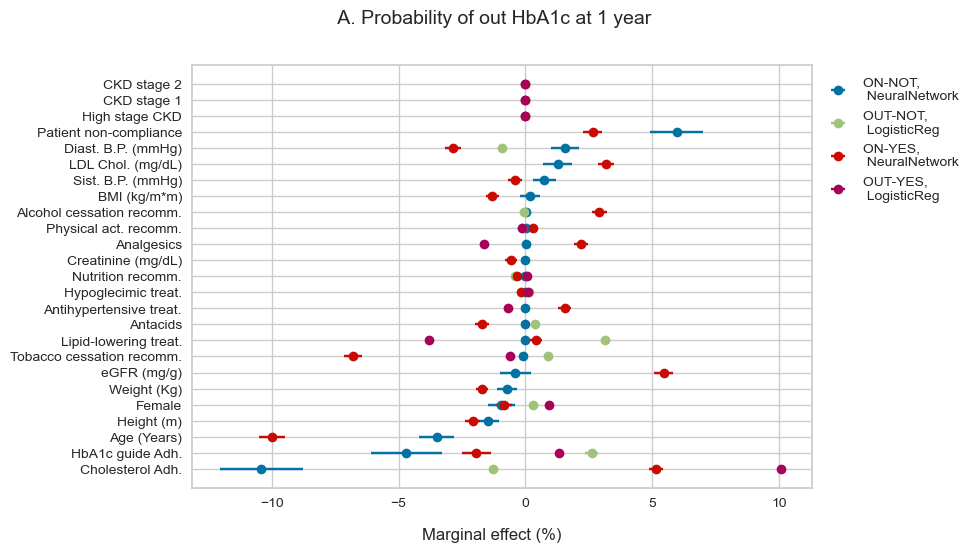

In [46]:
## Append de todos los resultados 
all_results = pd.read_csv(temp_path+'marginals_results.csv')
#all_results = pd.concat(all_margs, axis = 0)

## Seleccionando la transición y horizonte específicos
dep_var = "fuera_metas"
tgt_year = 1
plot_res = all_results[(all_results['Dependent variable'] == dep_var) & (all_results['Time Horizon'] == tgt_year)]

# Computando estadísticos adicionales
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['se'] = plot_res['std']/plot_res['n']**0.5
plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
plot_res['ci'] = plot_res['ub']-plot_res['lb']

# Eliminando superficie corporal 
plot_res = plot_res[plot_res['Variable'] != "super_corporal"]

# Renombrando variables para el gráfico
plot_res['Variable'].replace(to_replace = ["ERC1", 
                                           "ERC2", 
                                           "ERC_high", 
                                           "Antihypertensive", 
                                           "Lipid-lowering agents",
                                           "Hypoglecimic agents", 
                                           "Antacdis", 
                                           "Tobacco recomm.", 
                                           "Alcohol recomm.", 
                                           "Chol. Adh.", 
                                           "Hba1c guide Adh.", 
                                           "Pharma. Adh."],
                             value = ['CKD stage 1', 
                                      "CKD stage 2", 
                                      "High stage CKD", 
                                      "Antihypertensive treat.", 
                                      "Lipid-lowering treat.", 
                                      "Hypoglecimic treat.", 
                                      "Antacids", 
                                      "Tobacco cessation recomm.", 
                                      "Alcohol cessation recomm.", 
                                      "Cholesterol Adh.", 
                                      "HbA1c guide Adh.", 
                                      "Patient non-compliance"], 
                             inplace = True)

# Generando el gráfico combinado
fig = plt.figure()

for base_label in [1, 2, 3, 4]:
    tgt_data = plot_res[plot_res['base_label'] == base_label].reset_index(drop = True)
    
        ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "ON"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "OUT"

    if base_label<3:
        comorb_title = "NOT"
    elif base_label>2: 
        comorb_title = "YES"

    model_type = tgt_data.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "{}-{}, \n {}".format(hba1c_title, comorb_title, model_type)
    
    if base_label == 1:
        tgt_data.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)
    

    plt.errorbar(x = tgt_data['pctg'],
                 y = tgt_data['Variable'], 
                 xerr = tgt_data["ci"], 
                 marker = 'o', 
                 linestyle = 'None', 
                 label = plot_title)
    
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1,1))
    #plt.legend(loc = 'upper center', shadow = True, bbox_to_anchor=(1.04,1))
    
    
#fig.suptitle(, fontsize = 18)
fig.suptitle(" A. Probability of out HbA1c at {} year".format(tgt_year), fontsize = 14)
fig.supxlabel("Marginal effect (%)", fontsize = 12)

#fig.tight_layout()
plt.savefig(created_path+"ml_plots\\all_pr_effects\\metas_t1.png", bbox_inches="tight")

#### Gráfico vertical efectos marginales - Desviación de metas -  t+2

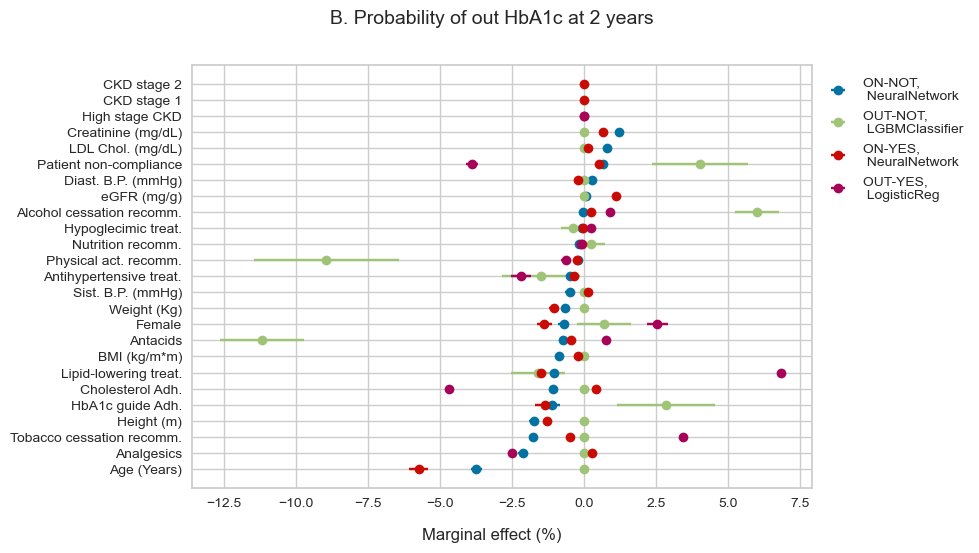

In [47]:
## Append de todos los resultados 
all_results = pd.read_csv(temp_path+'marginals_results.csv')
#all_results = pd.concat(all_margs, axis = 0)

## Seleccionando la transición y horizonte específicos
dep_var = "fuera_metas"
tgt_year = 2
plot_res = all_results[(all_results['Dependent variable'] == dep_var) & (all_results['Time Horizon'] == tgt_year)]

# Computando estadísticos adicionales
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['se'] = plot_res['std']/plot_res['n']**0.5
plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
plot_res['ci'] = plot_res['ub']-plot_res['lb']

# Eliminando superficie corporal 
plot_res = plot_res[plot_res['Variable'] != "super_corporal"]

# Renombrando variables para el gráfico
plot_res['Variable'].replace(to_replace = ["ERC1", 
                                           "ERC2", 
                                           "ERC_high", 
                                           "Antihypertensive", 
                                           "Lipid-lowering agents",
                                           "Hypoglecimic agents", 
                                           "Antacdis", 
                                           "Tobacco recomm.", 
                                           "Alcohol recomm.", 
                                           "Chol. Adh.", 
                                           "Hba1c guide Adh.", 
                                           "Pharma. Adh."],
                             value = ['CKD stage 1', 
                                      "CKD stage 2", 
                                      "High stage CKD", 
                                      "Antihypertensive treat.", 
                                      "Lipid-lowering treat.", 
                                      "Hypoglecimic treat.", 
                                      "Antacids", 
                                      "Tobacco cessation recomm.", 
                                      "Alcohol cessation recomm.", 
                                      "Cholesterol Adh.", 
                                      "HbA1c guide Adh.", 
                                      "Patient non-compliance"], 
                             inplace = True)

# Generando el gráfico combinado
fig = plt.figure()

for base_label in [1, 2, 3, 4]:
    tgt_data = plot_res[plot_res['base_label'] == base_label].reset_index(drop = True)
    
        ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "ON"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "OUT"

    if base_label<3:
        comorb_title = "NOT"
    elif base_label>2: 
        comorb_title = "YES"

    model_type = tgt_data.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "{}-{}, \n {}".format(hba1c_title, comorb_title, model_type)
    
    if base_label == 1:
        tgt_data.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)
    

    plt.errorbar(x = tgt_data['pctg'],
                 y = tgt_data['Variable'], 
                 xerr = tgt_data["ci"], 
                 marker = 'o', 
                 linestyle = 'None', 
                 label = plot_title)
    
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1,1))
    #plt.legend(loc = 'upper center', shadow = True, bbox_to_anchor=(1.04,1))
    
    
#fig.suptitle(, fontsize = 18)
fig.suptitle("B. Probability of out HbA1c at {} years".format(tgt_year), fontsize = 14)
fig.supxlabel("Marginal effect (%)", fontsize = 12)

#fig.tight_layout()
plt.savefig(created_path+"ml_plots\\all_pr_effects\\metas_t2.png", bbox_inches="tight")

#### Gráfico vertical efectos marginales - Comorbilidades

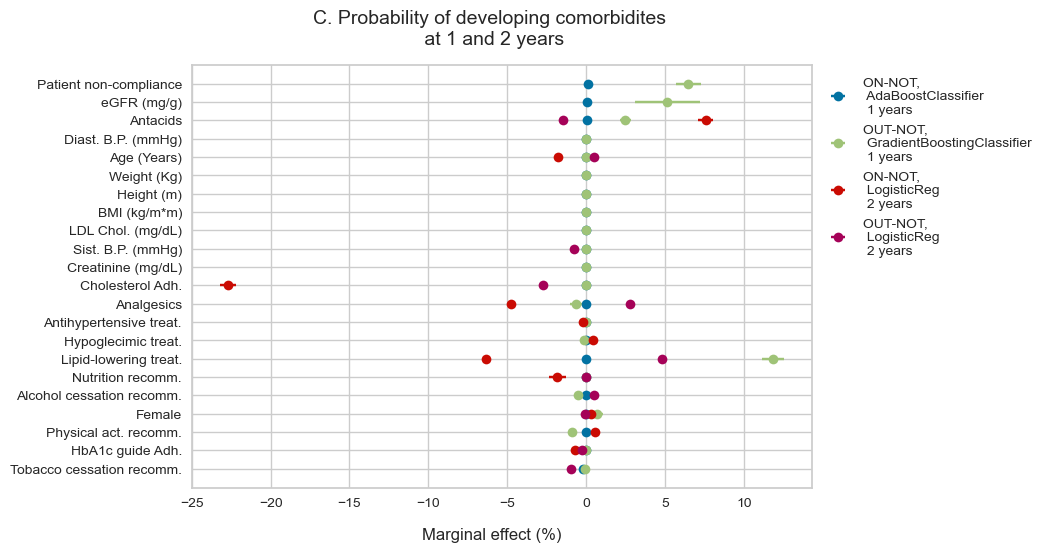

In [74]:
## Append de todos los resultados 
all_results = pd.read_csv(temp_path+'marginals_results.csv')
#all_results = pd.concat(all_margs, axis = 0)

## Seleccionando la transición y horizonte específicos
dep_var = "comorbilidades"
plot_res = all_results[(all_results['Dependent variable'] == dep_var)] # & (all_results['Time Horizon'] == tgt_year)]

# Computando estadísticos adicionales
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['se'] = plot_res['std']/plot_res['n']**0.5
plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
plot_res['ci'] = plot_res['ub']-plot_res['lb']

# Eliminando superficie corporal 
plot_res = plot_res[plot_res['Variable'] != "super_corporal"]

# Renombrando variables para el gráfico
plot_res['Variable'].replace(to_replace = ["ERC1", 
                                           "ERC2", 
                                           "ERC_high", 
                                           "Antihypertensive", 
                                           "Lipid-lowering agents",
                                           "Hypoglecimic agents", 
                                           "Antacdis", 
                                           "Tobacco recomm.", 
                                           "Alcohol recomm.", 
                                           "Chol. Adh.", 
                                           "Hba1c guide Adh.", 
                                           "Pharma. Adh."],
                             value = ['CKD stage 1', 
                                      "CKD stage 2", 
                                      "High stage CKD", 
                                      "Antihypertensive treat.", 
                                      "Lipid-lowering treat.", 
                                      "Hypoglecimic treat.", 
                                      "Antacids", 
                                      "Tobacco cessation recomm.", 
                                      "Alcohol cessation recomm.", 
                                      "Cholesterol Adh.", 
                                      "HbA1c guide Adh.", 
                                      "Patient non-compliance"], 
                             inplace = True)

# Generando el gráfico combinado
fig = plt.figure()
for tgt_year in [1, 2]:
    sub_tgt_data = plot_res[plot_res['Time Horizon'] == tgt_year].reset_index(drop = True)
    for base_label in [1, 2]:
        #tgt_data = plot_res[plot_res['Time Horizon'] == tgt_year].reset_index(drop = True)
        tgt_data = sub_tgt_data[sub_tgt_data['base_label'] == base_label].reset_index(drop = True)

            ## Set up del título
        if base_label == 1 or base_label == 3:
            hba1c_title = "ON"
        elif base_label == 2 or base_label == 4:
            hba1c_title = "OUT"

        if base_label<3:
            comorb_title = "NOT"
        elif base_label>2: 
            comorb_title = "YES"

        model_type = tgt_data.loc[0, 'Model type']

        ## Set up del eje y 
        if dep_var == "comorbilidades":
            y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
        elif dep_var == "fuera_metas":
            y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

        plot_title = "{}-{}, \n {} \n {} years".format(hba1c_title, comorb_title, model_type, tgt_year)

        if base_label == 1:
            tgt_data.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)


        plt.errorbar(x = tgt_data['pctg'],
                     y = tgt_data['Variable'], 
                     xerr = tgt_data["ci"], 
                     marker = 'o', 
                     linestyle = 'None', 
                     label = plot_title)

        #plt.legend(loc='best')
        plt.legend(bbox_to_anchor=(1,1))
        #plt.legend(loc = 'upper center', shadow = True, bbox_to_anchor=(1.04,1))


    #fig.suptitle(, fontsize = 18)
    fig.suptitle("C. Probability of developing comorbidites \n at 1 and 2 years", fontsize = 14)
    fig.supxlabel("Marginal effect (%)", fontsize = 12)

    #fig.tight_layout()
    plt.savefig(created_path+"ml_plots\\all_pr_effects\\comorb.png", bbox_inches="tight")

#### Gráfico vertical efectos marginales - Desviación de metas -  Sin comorbilidades

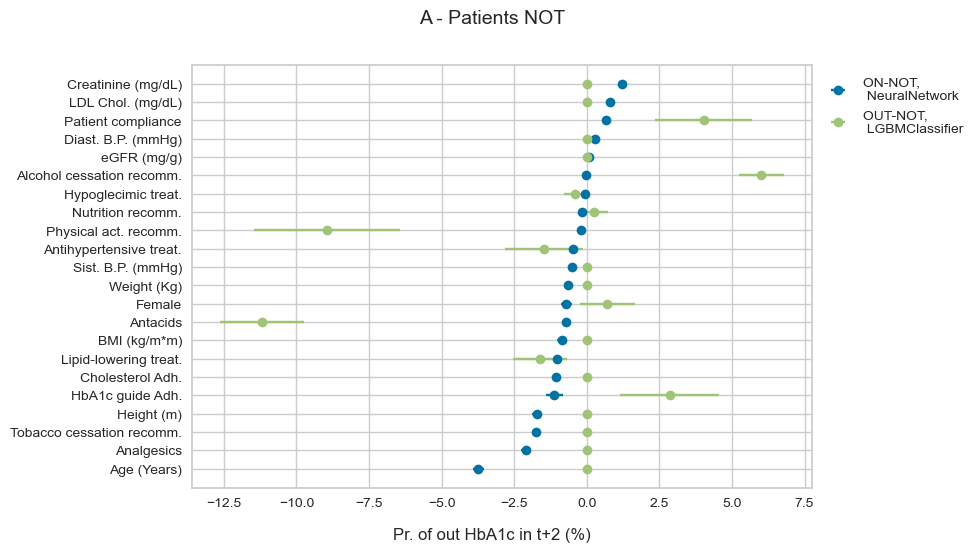

In [2]:
## Append de todos los resultados 
all_results = pd.read_csv(temp_path+'marginals_results.csv')
#all_results = pd.concat(all_margs, axis = 0)

## Seleccionando la transición y horizonte específicos
dep_var = "fuera_metas"
tgt_year = 2
plot_res = all_results[(all_results['Dependent variable'] == dep_var) & (all_results['Time Horizon'] == tgt_year)]

# Computando estadísticos adicionales
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['se'] = plot_res['std']/plot_res['n']**0.5
plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
plot_res['ci'] = plot_res['ub']-plot_res['lb']

# Eliminando superficie corporal 
plot_res = plot_res[plot_res['Variable'] != "super_corporal"]

# Renombrando variables para el gráfico
plot_res['Variable'].replace(to_replace = ["ERC1", 
                                           "ERC2", 
                                           "ERC_high", 
                                           "Antihypertensive", 
                                           "Lipid-lowering agents",
                                           "Hypoglecimic agents", 
                                           "Antacdis", 
                                           "Tobacco recomm.", 
                                           "Alcohol recomm.", 
                                           "Chol. Adh.", 
                                           "Hba1c guide Adh.", 
                                           "Pharma. Adh."],
                             value = ['CKD stage 1', 
                                      "CKD stage 2", 
                                      "High stage CKD", 
                                      "Antihypertensive treat.", 
                                      "Lipid-lowering treat.", 
                                      "Hypoglecimic treat.", 
                                      "Antacids", 
                                      "Tobacco cessation recomm.", 
                                      "Alcohol cessation recomm.", 
                                      "Cholesterol Adh.", 
                                      "HbA1c guide Adh.", 
                                      "Patient compliance"], 
                             inplace = True)

# Generando el gráfico combinado
fig = plt.figure()

for base_label in [1, 2]: #, 3, 4]:
    tgt_data = plot_res[plot_res['base_label'] == base_label].reset_index(drop = True)
    
        ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "ON"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "OUT"

    if base_label<3:
        comorb_title = "NOT"
    elif base_label>2: 
        comorb_title = "YES"

    model_type = tgt_data.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "{}-{}, \n {}".format(hba1c_title, comorb_title, model_type)
    
    if base_label == 1:
        tgt_data.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)
    

    plt.errorbar(x = tgt_data['pctg'],
                 y = tgt_data['Variable'], 
                 xerr = tgt_data["ci"], 
                 marker = 'o', 
                 linestyle = 'None', 
                 label = plot_title)
    
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1,1))
    #plt.legend(loc = 'upper center', shadow = True, bbox_to_anchor=(1.04,1))
    
    
#fig.suptitle(, fontsize = 18)
fig.suptitle("A - Patients NOT", fontsize = 14)
fig.supxlabel("Pr. of out HbA1c in t+2 (%)", fontsize = 12)

#fig.tight_layout()
plt.savefig(created_path+"ml_plots\\pr_effects\\all_effects_gathered_wo_comorb.png", bbox_inches="tight")

#### Gráfico vertical efectos marginales - Desviación de metas - Con comorbilidades

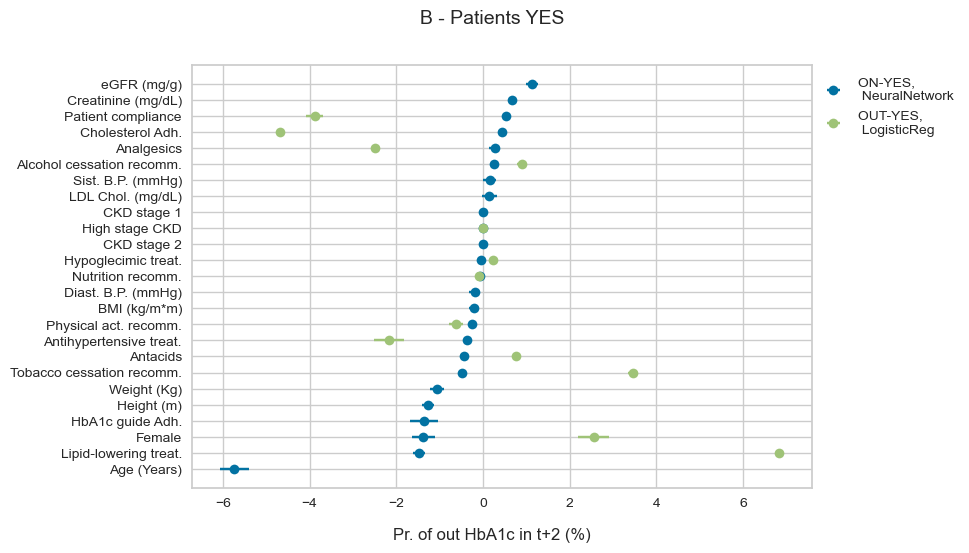

In [3]:
## Append de todos los resultados 
all_results = pd.read_csv(temp_path+'marginals_results.csv')
#all_results = pd.concat(all_margs, axis = 0)

## Seleccionando la transición y horizonte específicos
dep_var = "fuera_metas"
tgt_year = 2
plot_res = all_results[(all_results['Dependent variable'] == dep_var) & (all_results['Time Horizon'] == tgt_year)]

# Computando estadísticos adicionales
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['se'] = plot_res['std']/plot_res['n']**0.5
plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
plot_res['ci'] = plot_res['ub']-plot_res['lb']

# Eliminando superficie corporal 
plot_res = plot_res[plot_res['Variable'] != "super_corporal"]

# Renombrando variables para el gráfico
plot_res['Variable'].replace(to_replace = ["ERC1", 
                                           "ERC2", 
                                           "ERC_high", 
                                           "Antihypertensive", 
                                           "Lipid-lowering agents",
                                           "Hypoglecimic agents", 
                                           "Antacdis", 
                                           "Tobacco recomm.", 
                                           "Alcohol recomm.", 
                                           "Chol. Adh.", 
                                           "Hba1c guide Adh.", 
                                           "Pharma. Adh."],
                             value = ['CKD stage 1', 
                                      "CKD stage 2", 
                                      "High stage CKD", 
                                      "Antihypertensive treat.", 
                                      "Lipid-lowering treat.", 
                                      "Hypoglecimic treat.", 
                                      "Antacids", 
                                      "Tobacco cessation recomm.", 
                                      "Alcohol cessation recomm.", 
                                      "Cholesterol Adh.", 
                                      "HbA1c guide Adh.", 
                                      "Patient compliance"], 
                             inplace = True)

# Generando el gráfico combinado
fig = plt.figure()

for base_label in [3, 4]:
    tgt_data = plot_res[plot_res['base_label'] == base_label].reset_index(drop = True)
    
        ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "ON"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "OUT"

    if base_label<3:
        comorb_title = "NOT"
    elif base_label>2: 
        comorb_title = "YES"

    model_type = tgt_data.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "{}-{}, \n {}".format(hba1c_title, comorb_title, model_type)
    
    if base_label == 3:
        tgt_data.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)
    

    plt.errorbar(x = tgt_data['pctg'],
                 y = tgt_data['Variable'], 
                 xerr = tgt_data["ci"], 
                 marker = 'o', 
                 linestyle = 'None', 
                 label = plot_title)
    
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1.25,1))
    #plt.legend(loc = 'upper center', shadow = True, bbox_to_anchor=(1.04,1))
    
    
#fig.suptitle(, fontsize = 18)
fig.suptitle("B - Patients YES", fontsize = 14)
fig.supxlabel("Pr. of out HbA1c in t+2 (%)", fontsize = 12)

#fig.tight_layout()
plt.savefig(created_path+"ml_plots\\pr_effects\\all_effects_gathered_w_comorb.png", bbox_inches="tight")

#### Gráfico vertical efectos marginales - Desarrollo de comorbilidades - Sin comorbilidades

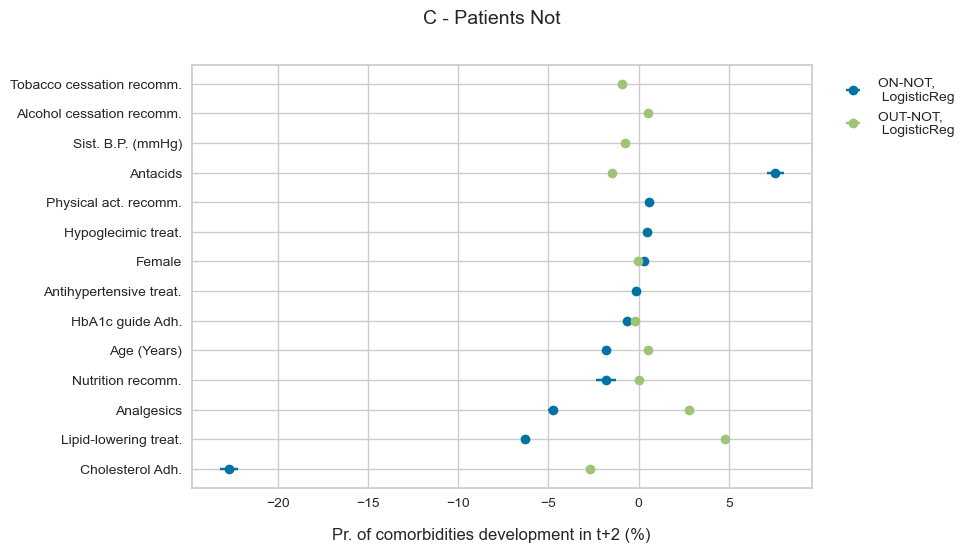

In [17]:
## Append de todos los resultados 
all_results = pd.read_csv(temp_path+'marginals_results.csv')
#all_results = pd.concat(all_margs, axis = 0)

## Seleccionando la transición y horizonte específicos
dep_var = "comorbilidades"
tgt_year = 2
plot_res = all_results[(all_results['Dependent variable'] == dep_var) & (all_results['Time Horizon'] == tgt_year)]

# Computando estadísticos adicionales
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['iqr'] = plot_res['p95']-plot_res['p5']
plot_res['se'] = plot_res['std']/plot_res['n']**0.5
plot_res['lb'] = plot_res['pctg']-1.98*plot_res['se']
plot_res['ub'] = plot_res['pctg']+1.98*plot_res['se']
plot_res['ci'] = plot_res['ub']-plot_res['lb']

# Eliminando superficie corporal 
plot_res = plot_res[plot_res['Variable'] != "super_corporal"]

# Renombrando variables para el gráfico
plot_res['Variable'].replace(to_replace = ["ERC1", 
                                           "ERC2", 
                                           "ERC_high", 
                                           "Antihypertensive", 
                                           "Lipid-lowering agents",
                                           "Hypoglecimic agents", 
                                           "Antacdis", 
                                           "Tobacco recomm.", 
                                           "Alcohol recomm.", 
                                           "Chol. Adh.", 
                                           "Hba1c guide Adh.", 
                                           "Pharma. Adh."],
                             value = ['CKD stage 1', 
                                      "CKD stage 2", 
                                      "High stage CKD", 
                                      "Antihypertensive treat.", 
                                      "Lipid-lowering treat.", 
                                      "Hypoglecimic treat.", 
                                      "Antacids", 
                                      "Tobacco cessation recomm.", 
                                      "Alcohol cessation recomm.", 
                                      "Cholesterol Adh.", 
                                      "HbA1c guide Adh.", 
                                      "Patient compliance"], 
                             inplace = True)

# Generando el gráfico combinado
fig = plt.figure()

for base_label in [1, 2]:
    tgt_data = plot_res[plot_res['base_label'] == base_label].reset_index(drop = True)
    
        ## Set up del título
    if base_label == 1 or base_label == 3:
        hba1c_title = "ON"
    elif base_label == 2 or base_label == 4:
        hba1c_title = "OUT"

    if base_label<3:
        comorb_title = "NOT"
    elif base_label>2: 
        comorb_title = "YES"

    model_type = tgt_data.loc[0, 'Model type']

    ## Set up del eje y 
    if dep_var == "comorbilidades":
        y_axis_label = "Effect on Pr. of developing comorbidites in t+{} (%)".format(tgt_year)
    elif dep_var == "fuera_metas":
        y_axis_label = "Effect on Pr. of HbA1c deviations in t+{} (%)".format(tgt_year)

    plot_title = "{}-{}, \n {}".format(hba1c_title, comorb_title, model_type)
    
    if base_label == 1:
        tgt_data.sort_values(by = 'pctg', inplace = True, ascending = True, axis = 0)
    

    plt.errorbar(x = tgt_data['pctg'],
                 y = tgt_data['Variable'], 
                 xerr = tgt_data["ci"], 
                 marker = 'o', 
                 linestyle = 'None', 
                 label = plot_title)
    
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1.25,1))
    #plt.legend(loc = 'upper center', shadow = True, bbox_to_anchor=(1.04,1))
    
    
#fig.suptitle(, fontsize = 18)
fig.suptitle("C - Patients Not", fontsize = 14)
fig.supxlabel("Pr. of comorbidities development in t+2 (%)", fontsize = 12)

#fig.tight_layout()
plt.savefig(created_path+"ml_plots\\pr_effects\\comorb_effects_gathered_wo_comorb.png", bbox_inches="tight")

#### Gráficos verticales de los efectos marginales

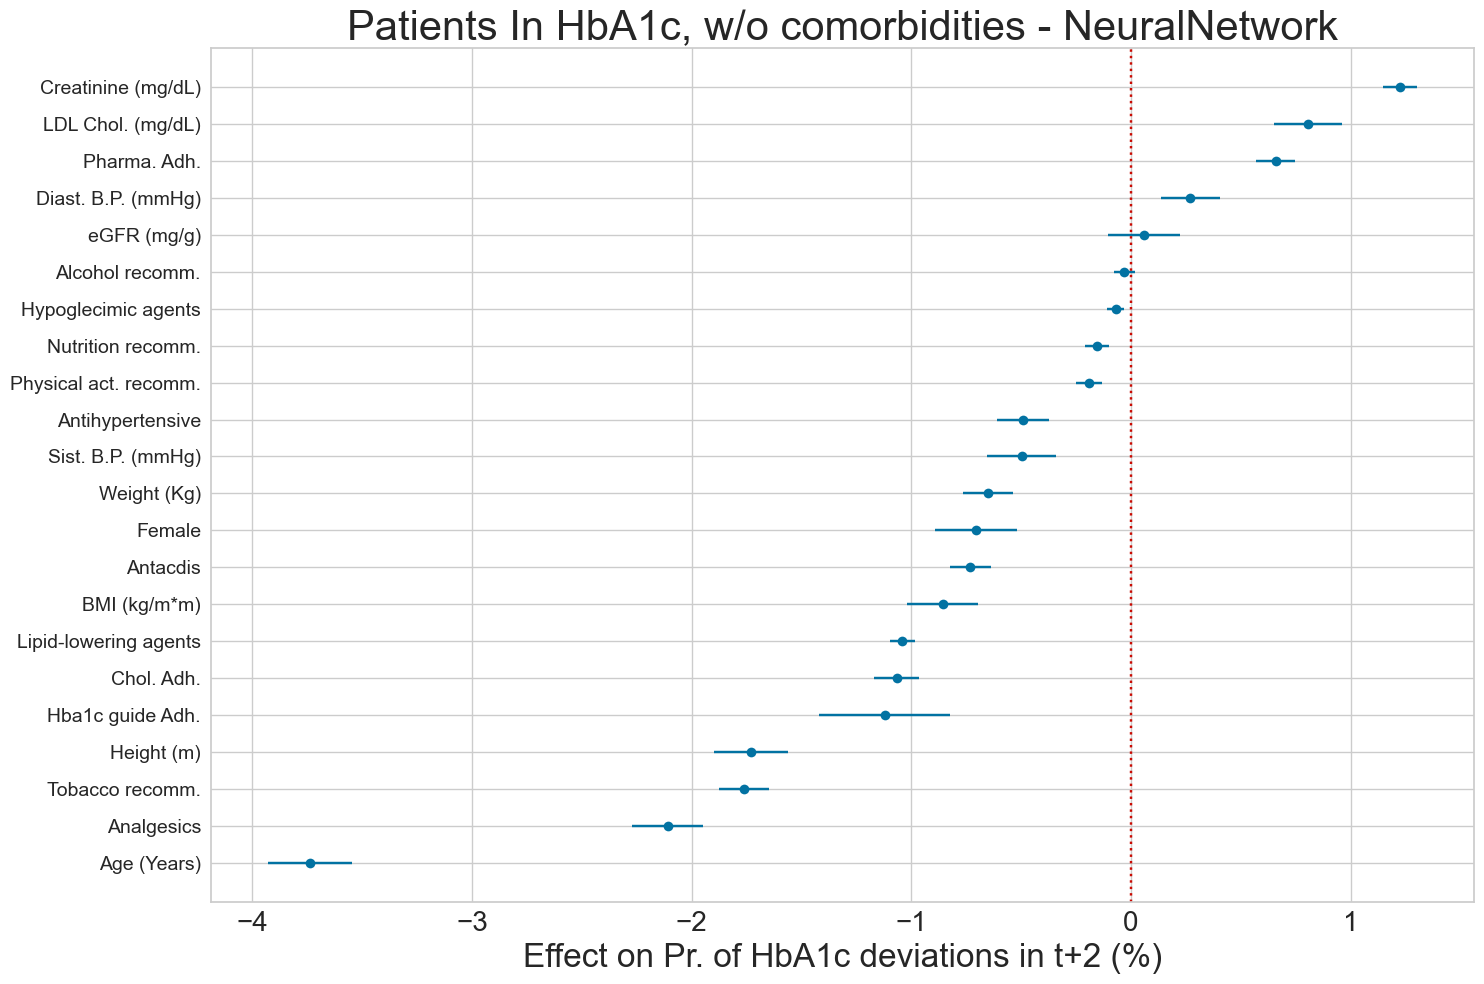

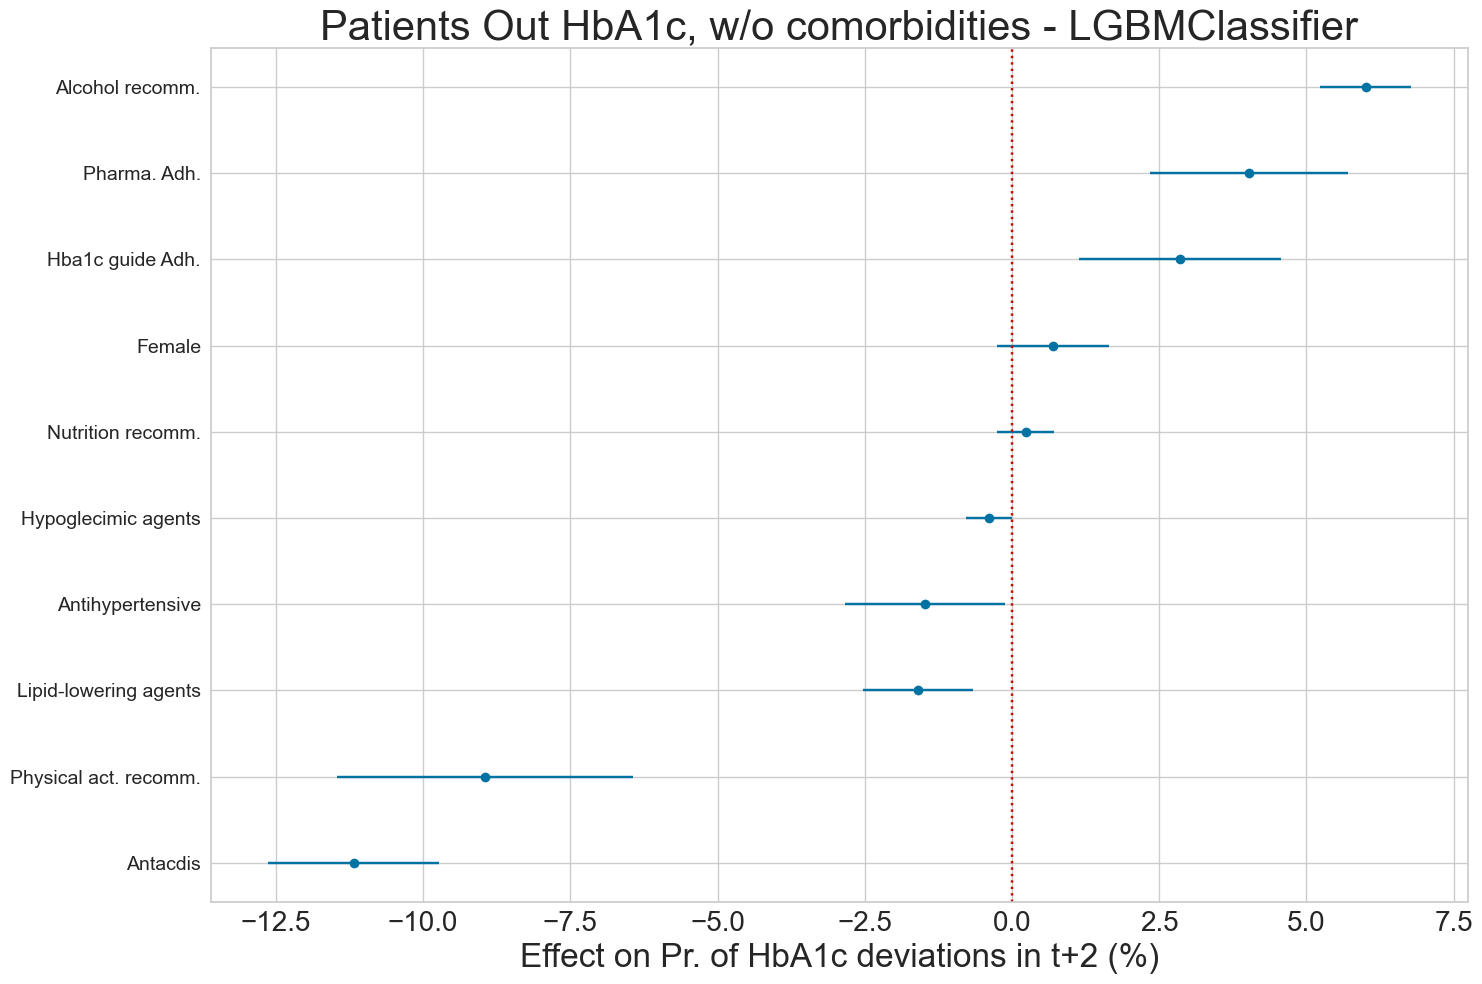

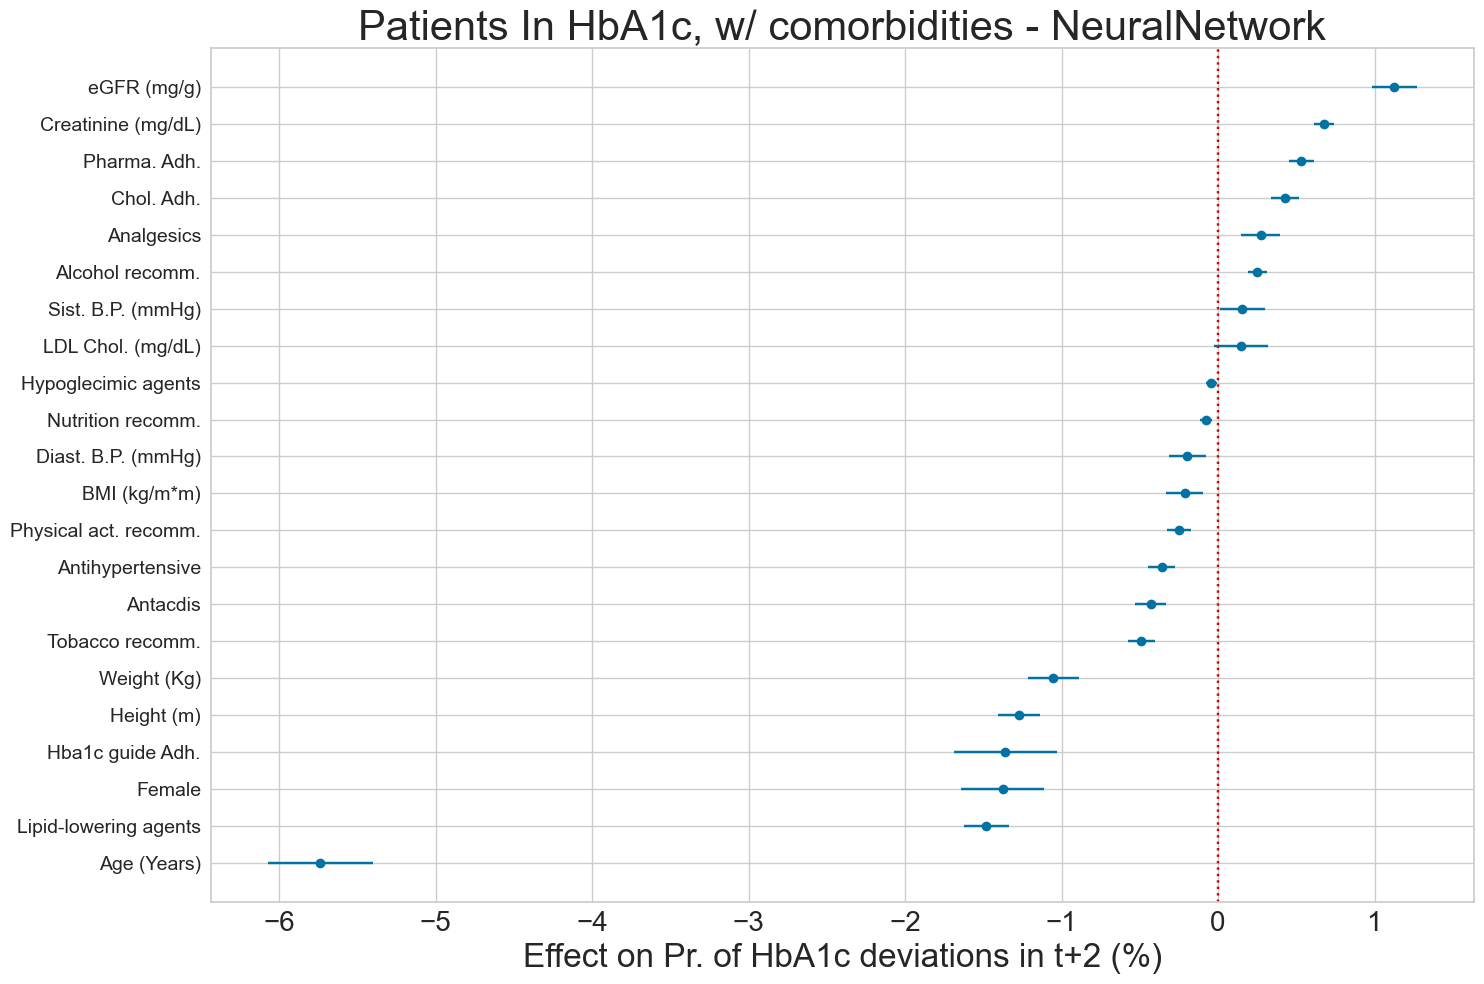

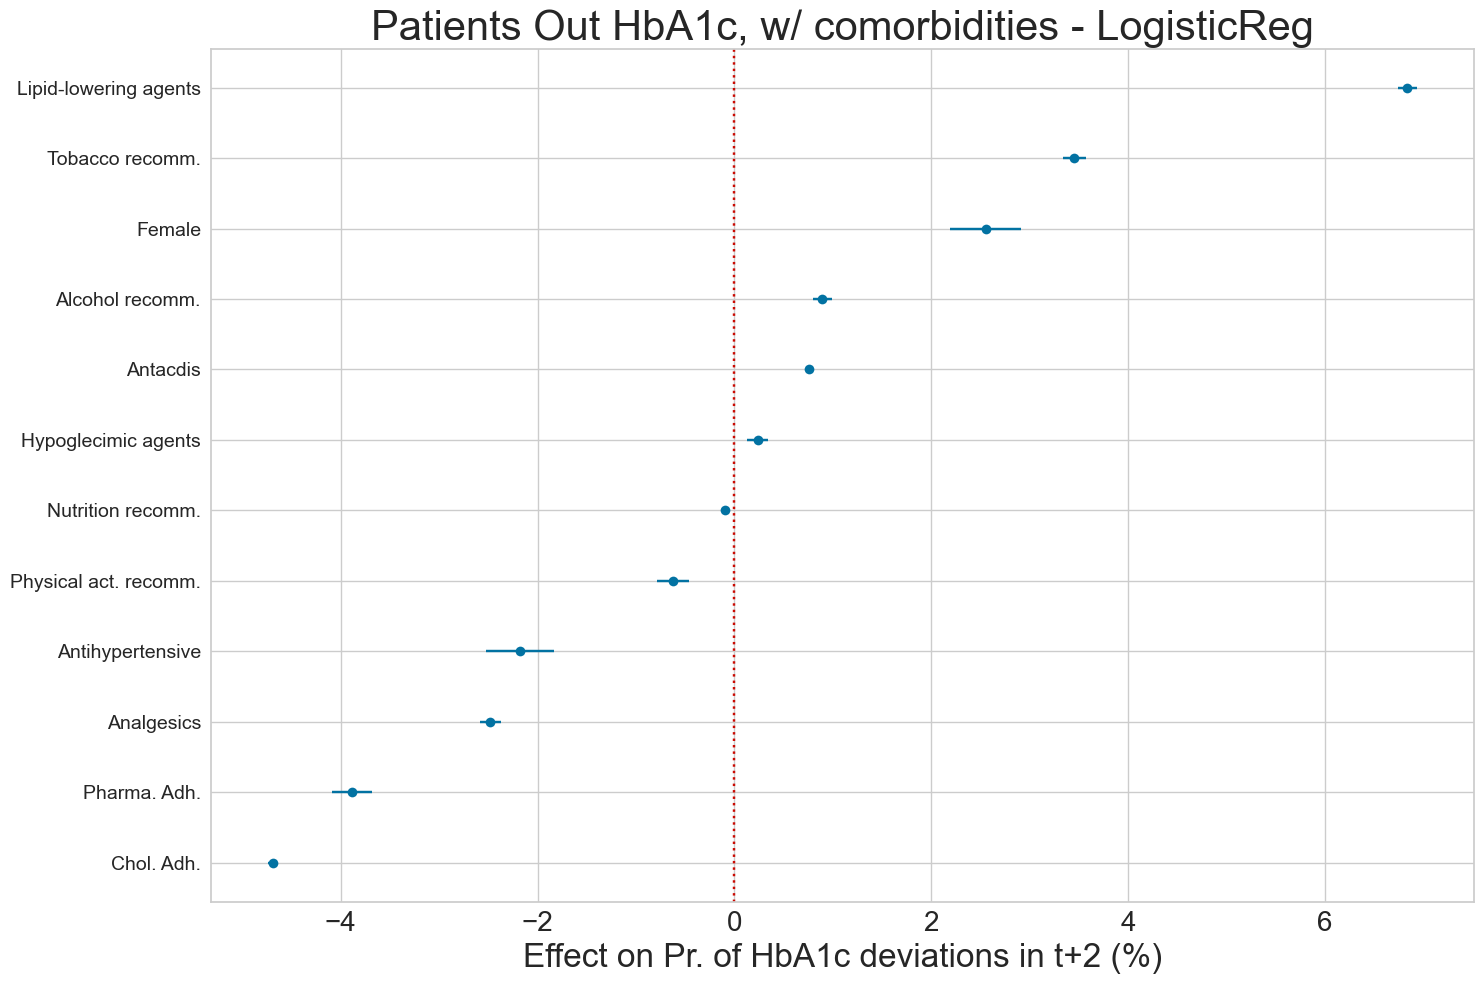

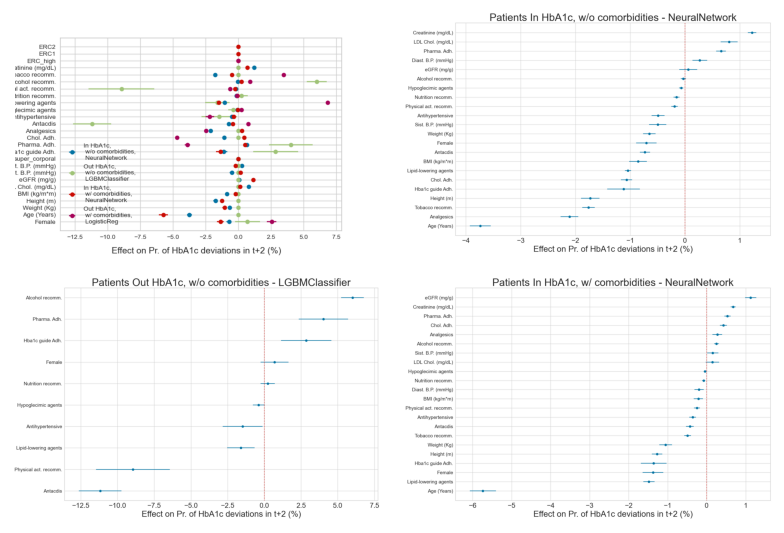

In [7]:
## Append de todos los resultados
#all_results = pd.concat(all_margs, axis = 0)

## Parámetros estáticos
dep_var = "fuera_metas"
tgt_year = 2

## Iterando entre estadios base para guardar el gráfico
for base_label in [1, 2, 3, 4]:
    vertical_coef_plotter(all_results = all_results, 
                          dep_var = dep_var, 
                          tgt_year = tgt_year,
                          base_label = base_label,
                          ci_stat = "ci")
    
## Enlistando los gráficos individuales
files_names = os.listdir(created_path+"ml_plots\\vertical_pr_effects\\")

## Iterando entre los archivos para generar el gráfico completo
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
    ax.set_axis_off()
    filename = created_path+"ml_plots\\vertical_pr_effects\\{}".format(files_names[i])
    ax.imshow(mpimg.imread(filename))
    #plt.tight_layout()
    #fig.tight_layout()

## Comprimiendo el gráfico y exportándolo
fig.tight_layout()
plt.savefig(created_path+"ml_plots\\pr_effects\\dev_effects_gathered_vertical.png")

#### Gráficos horizontales de los efectos marginales

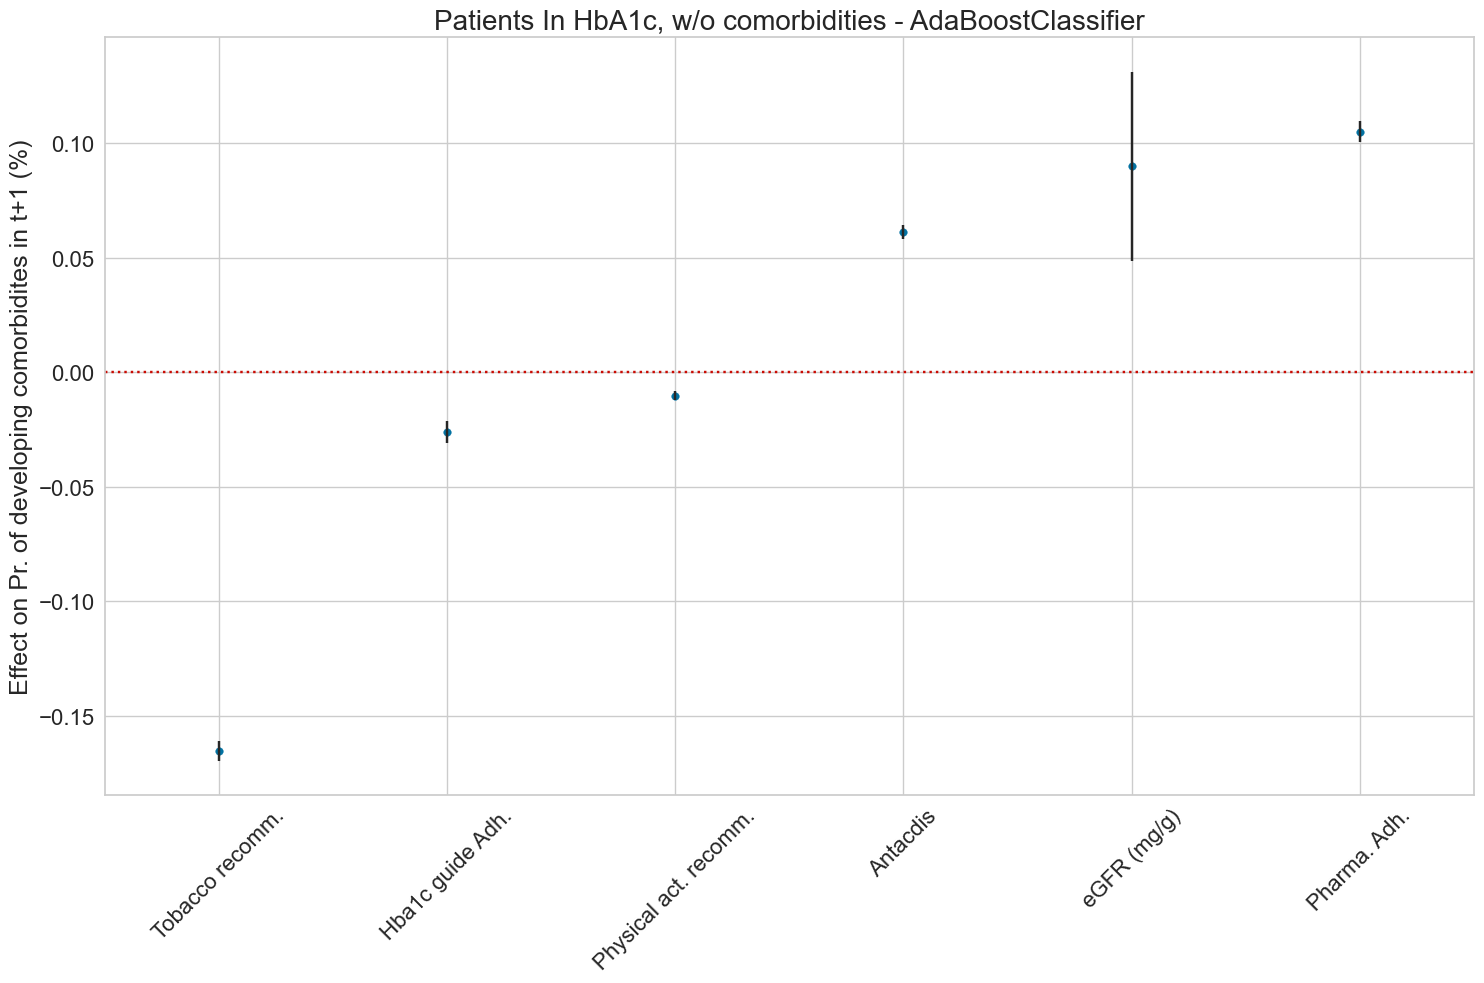

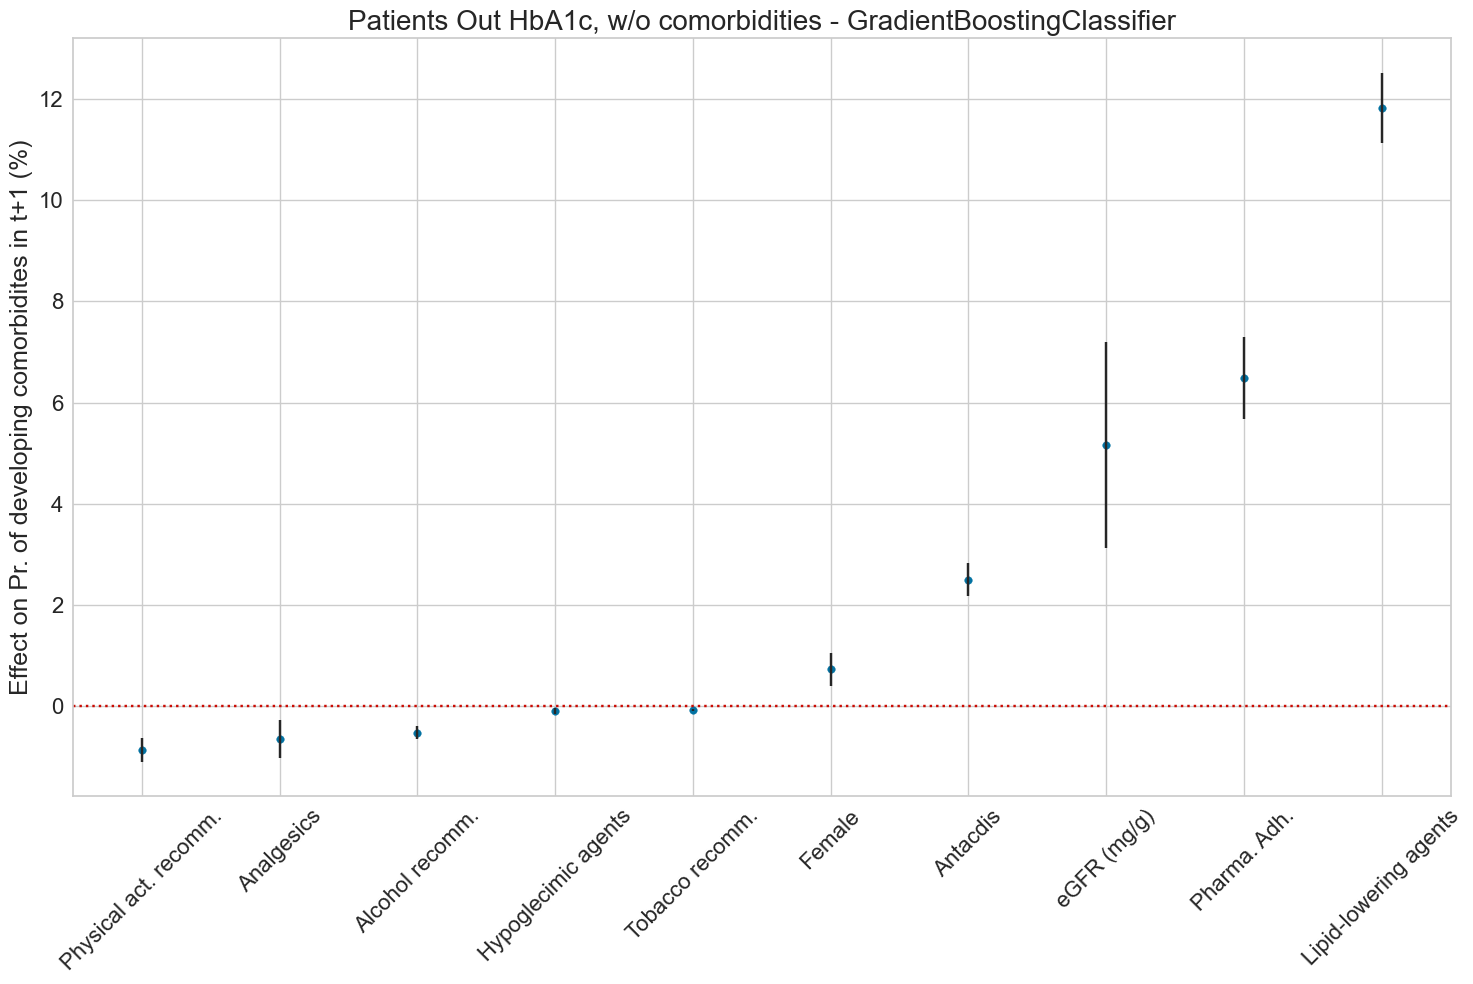

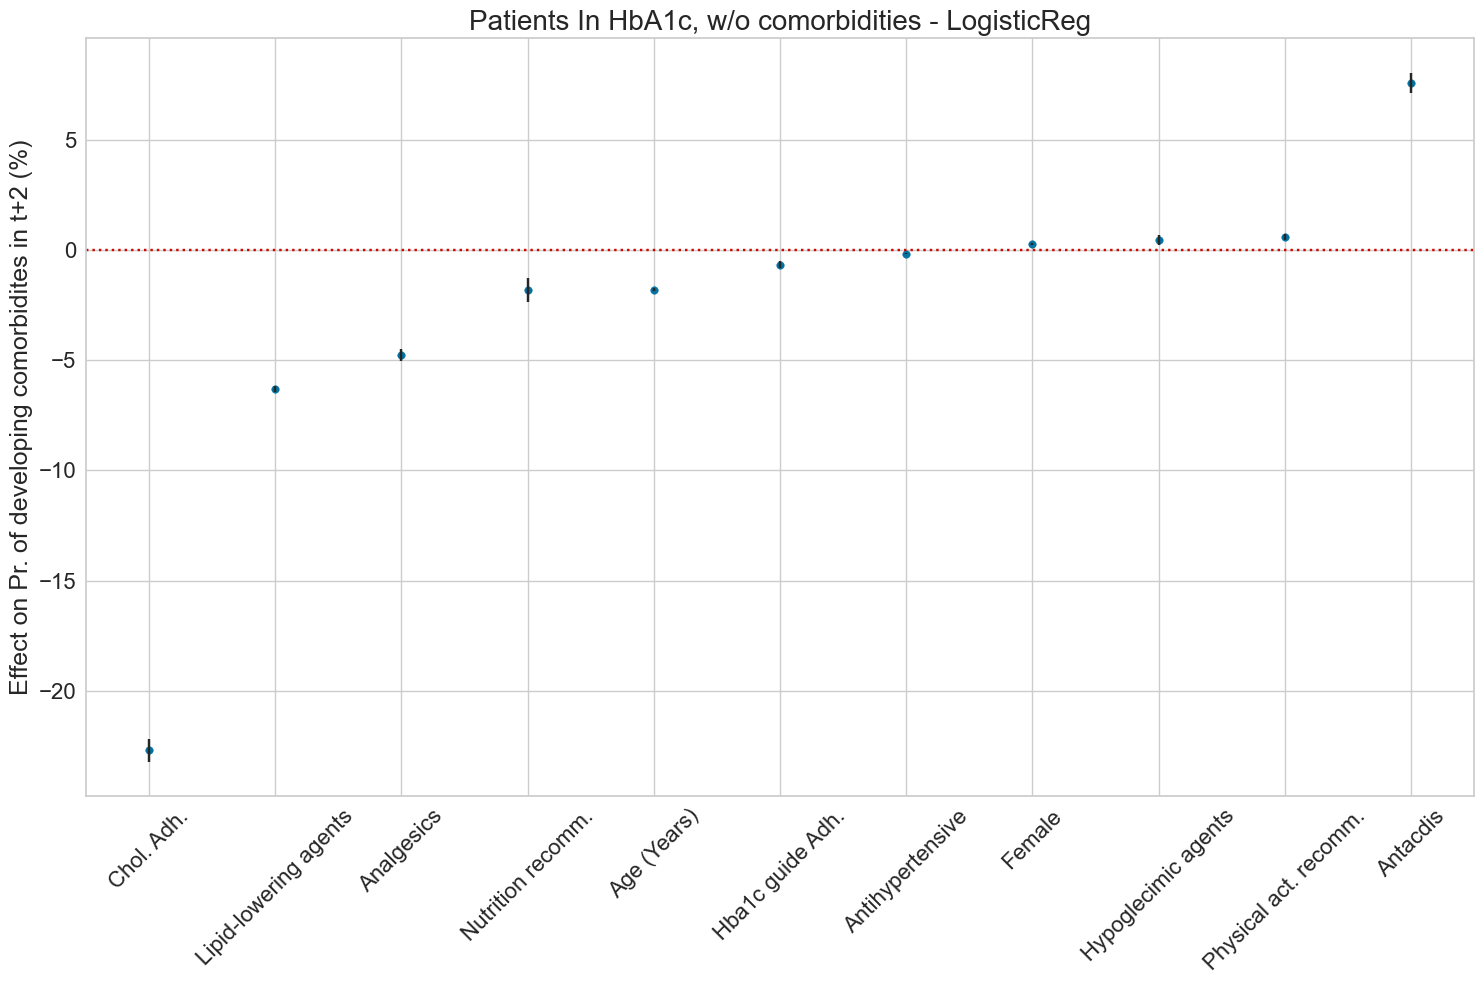

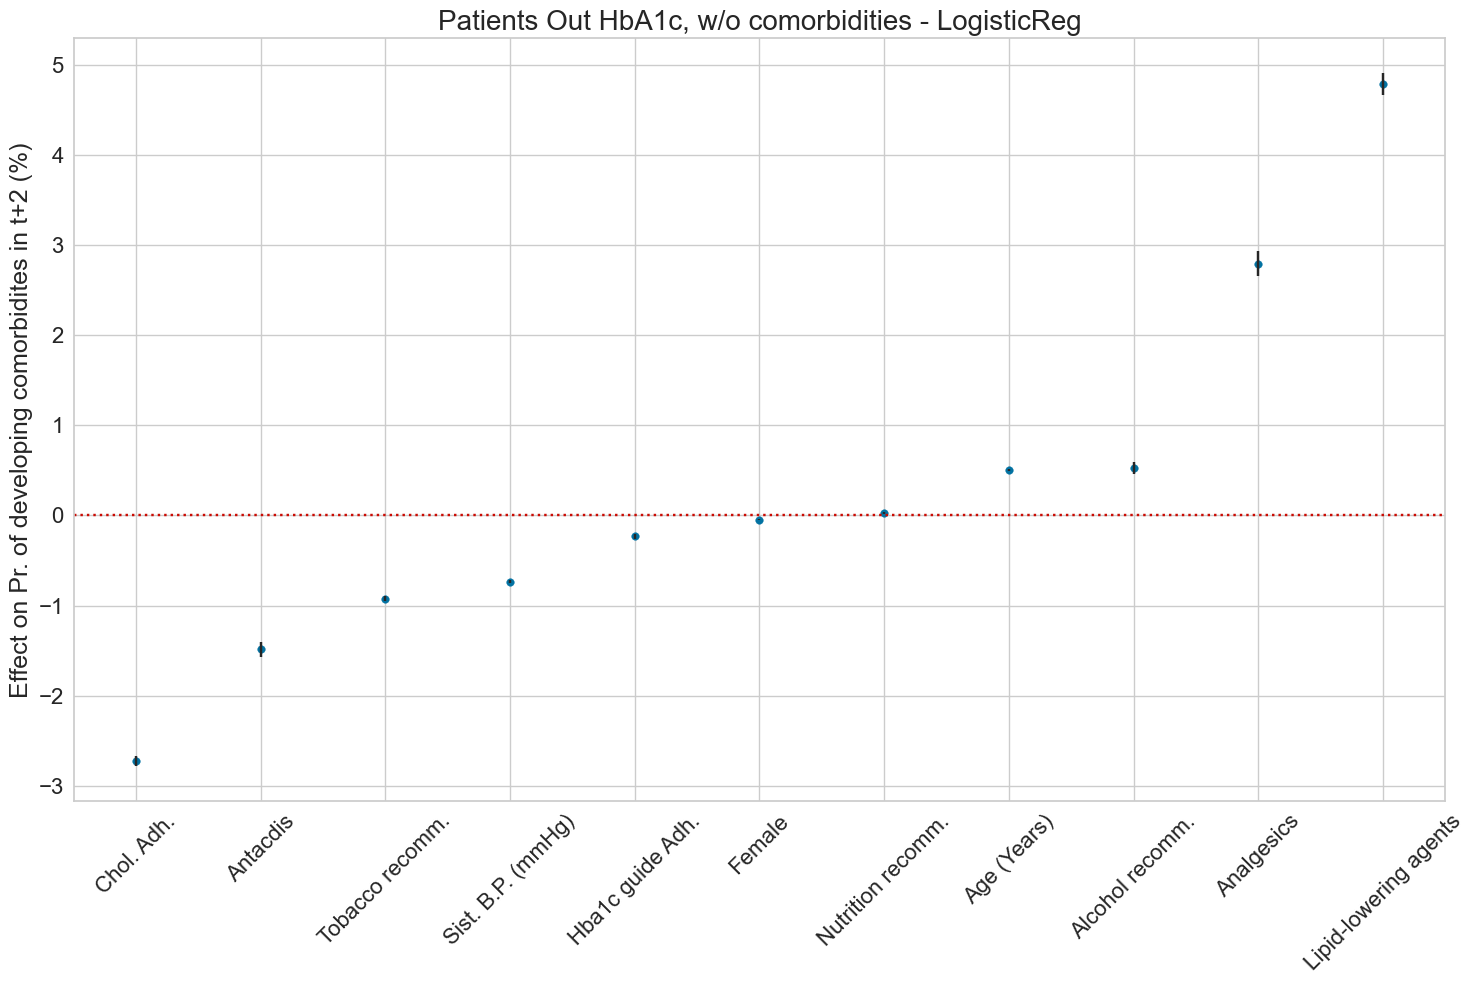

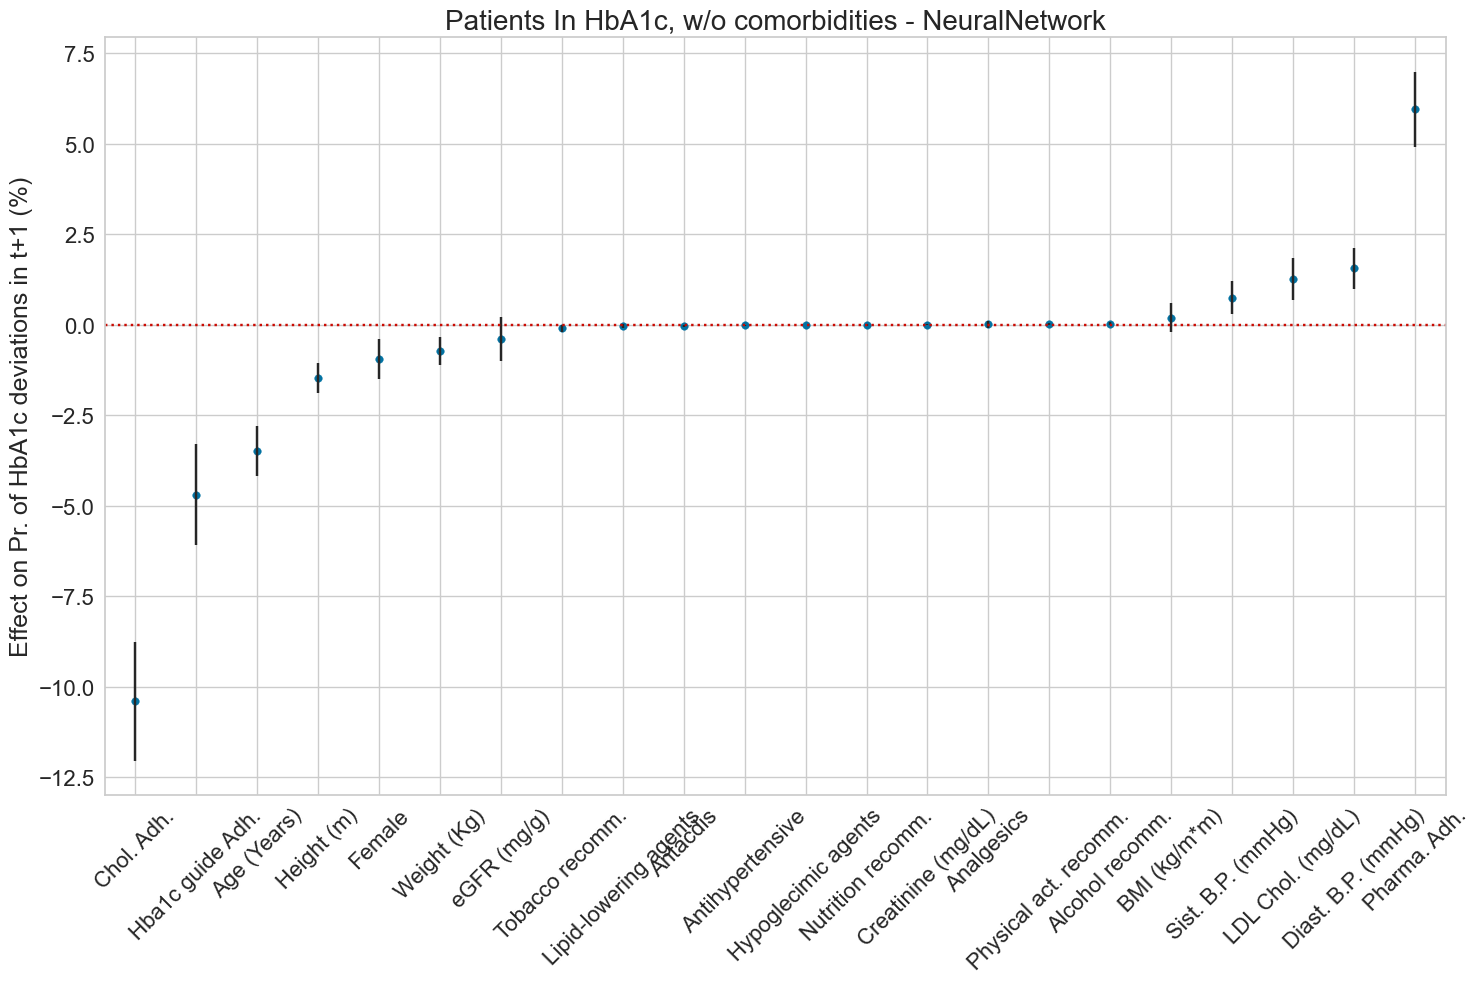

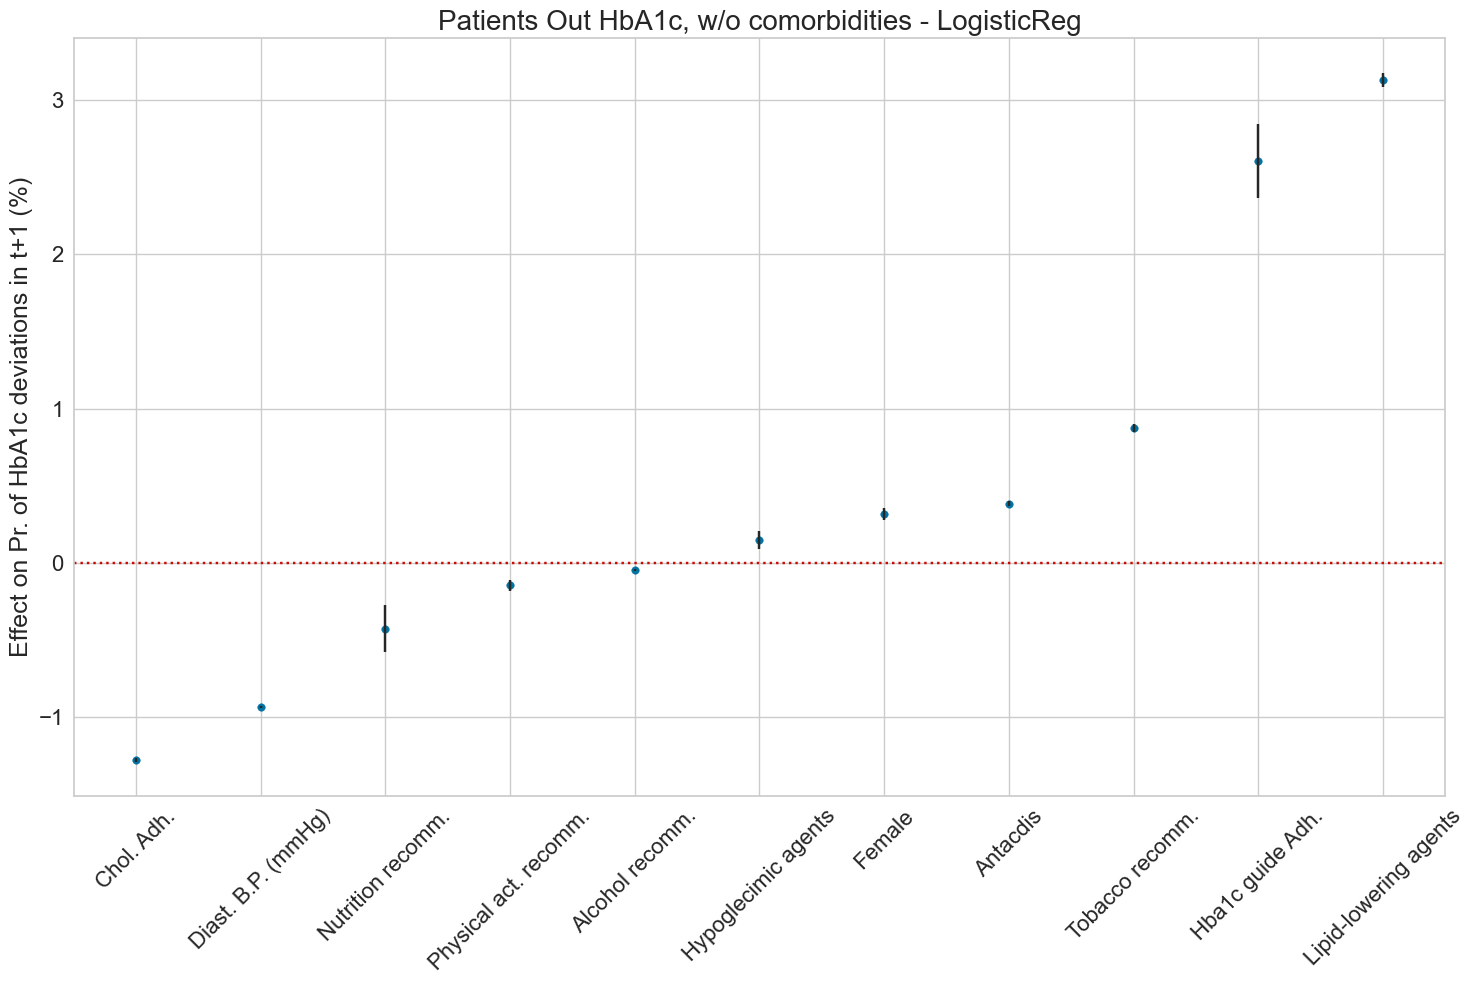

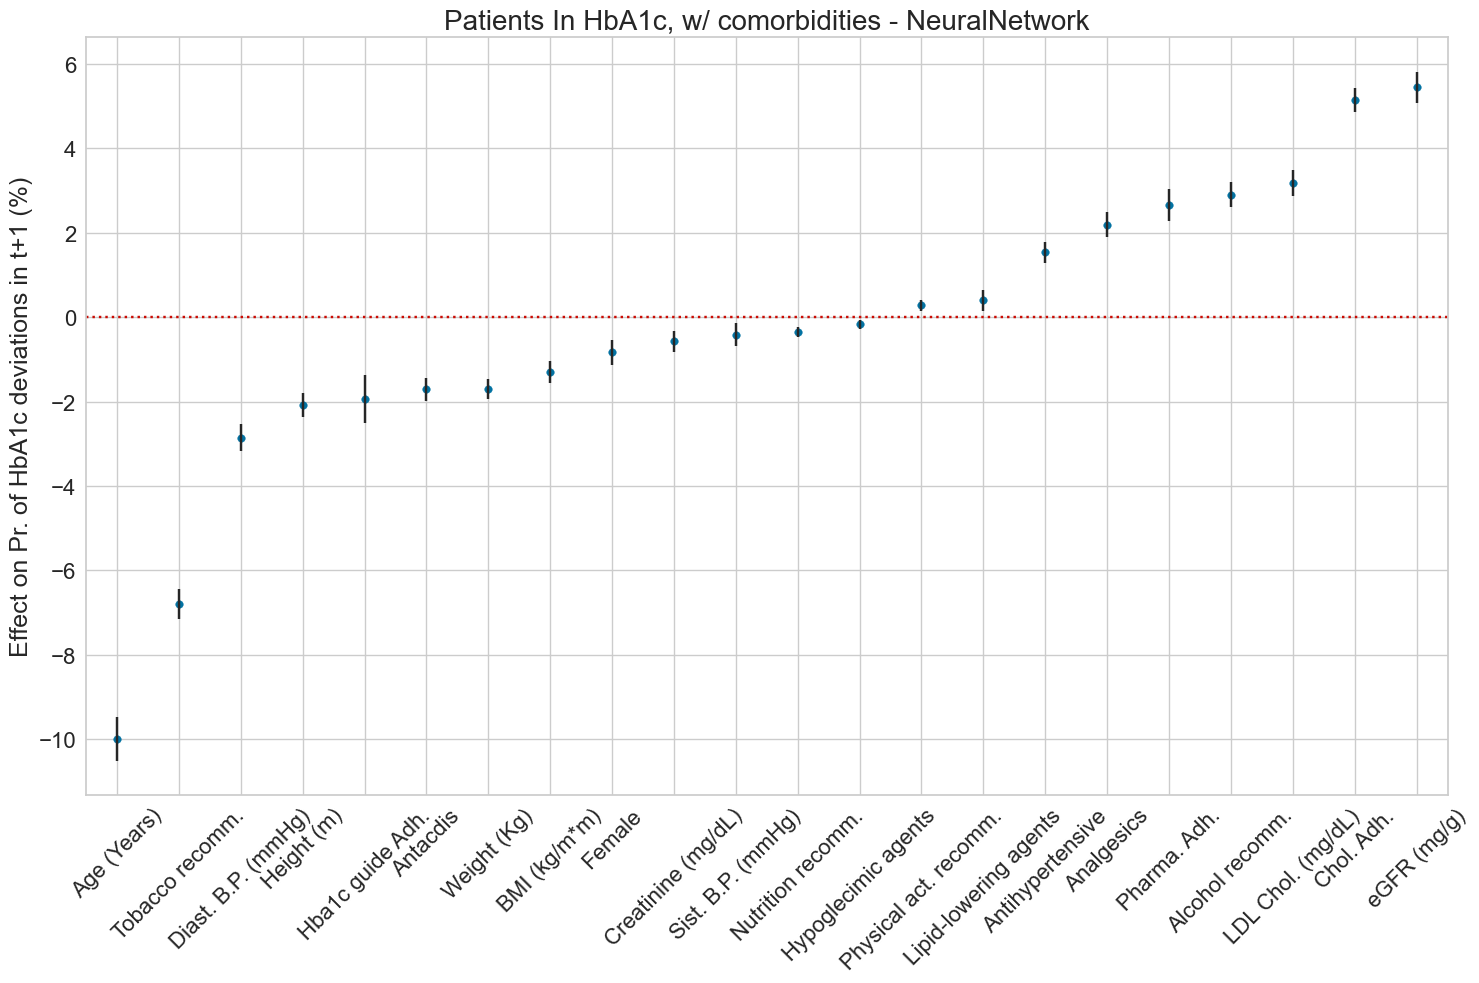

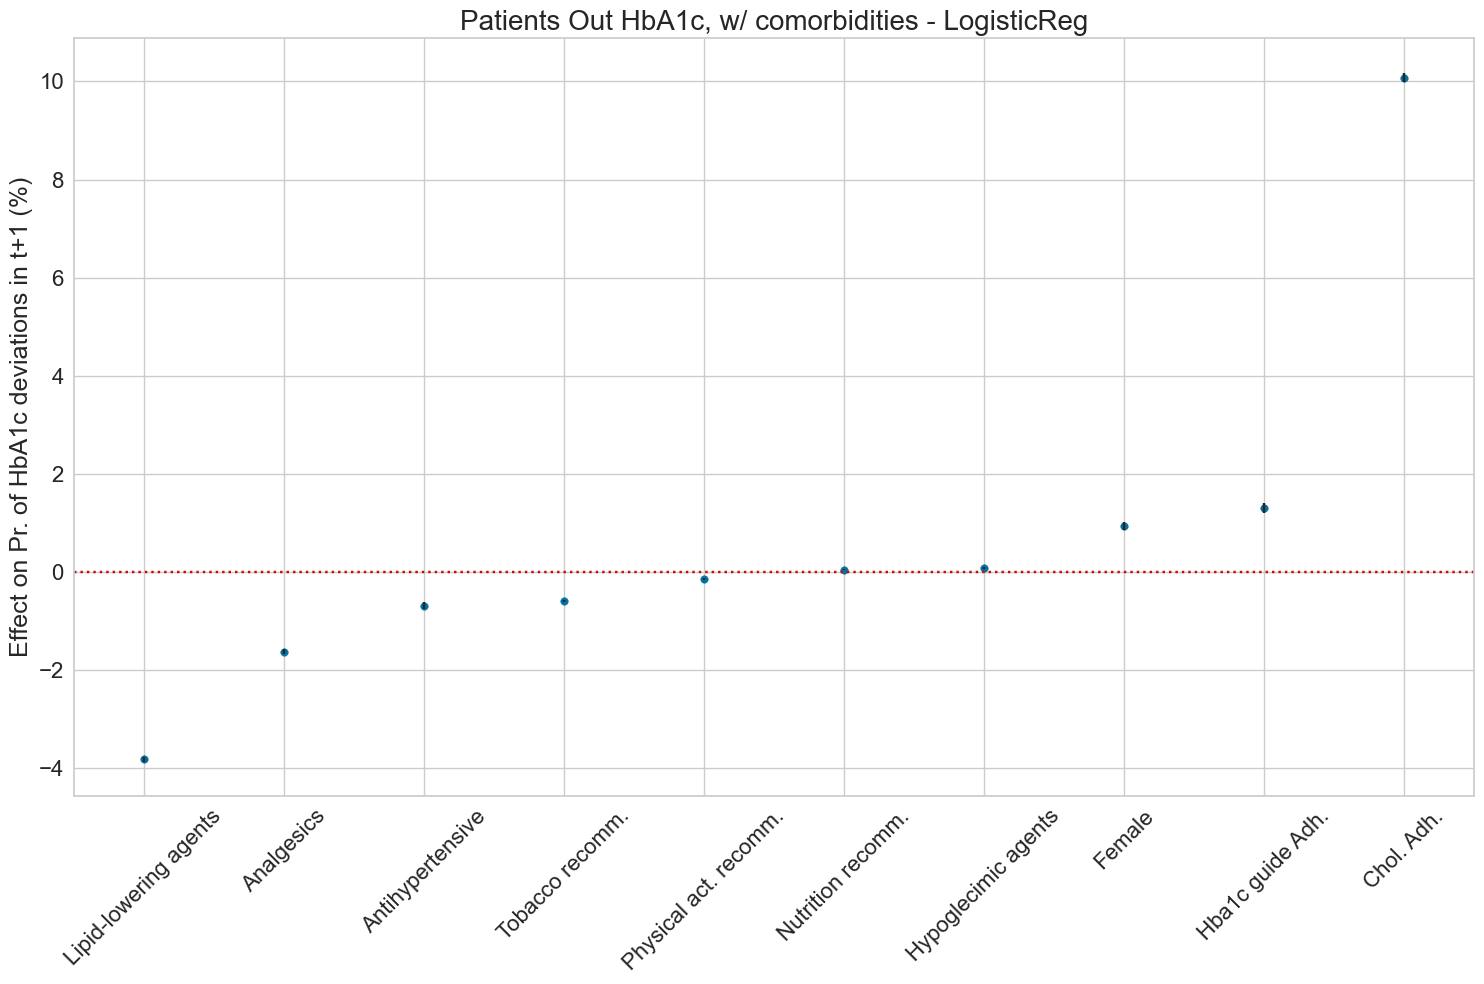

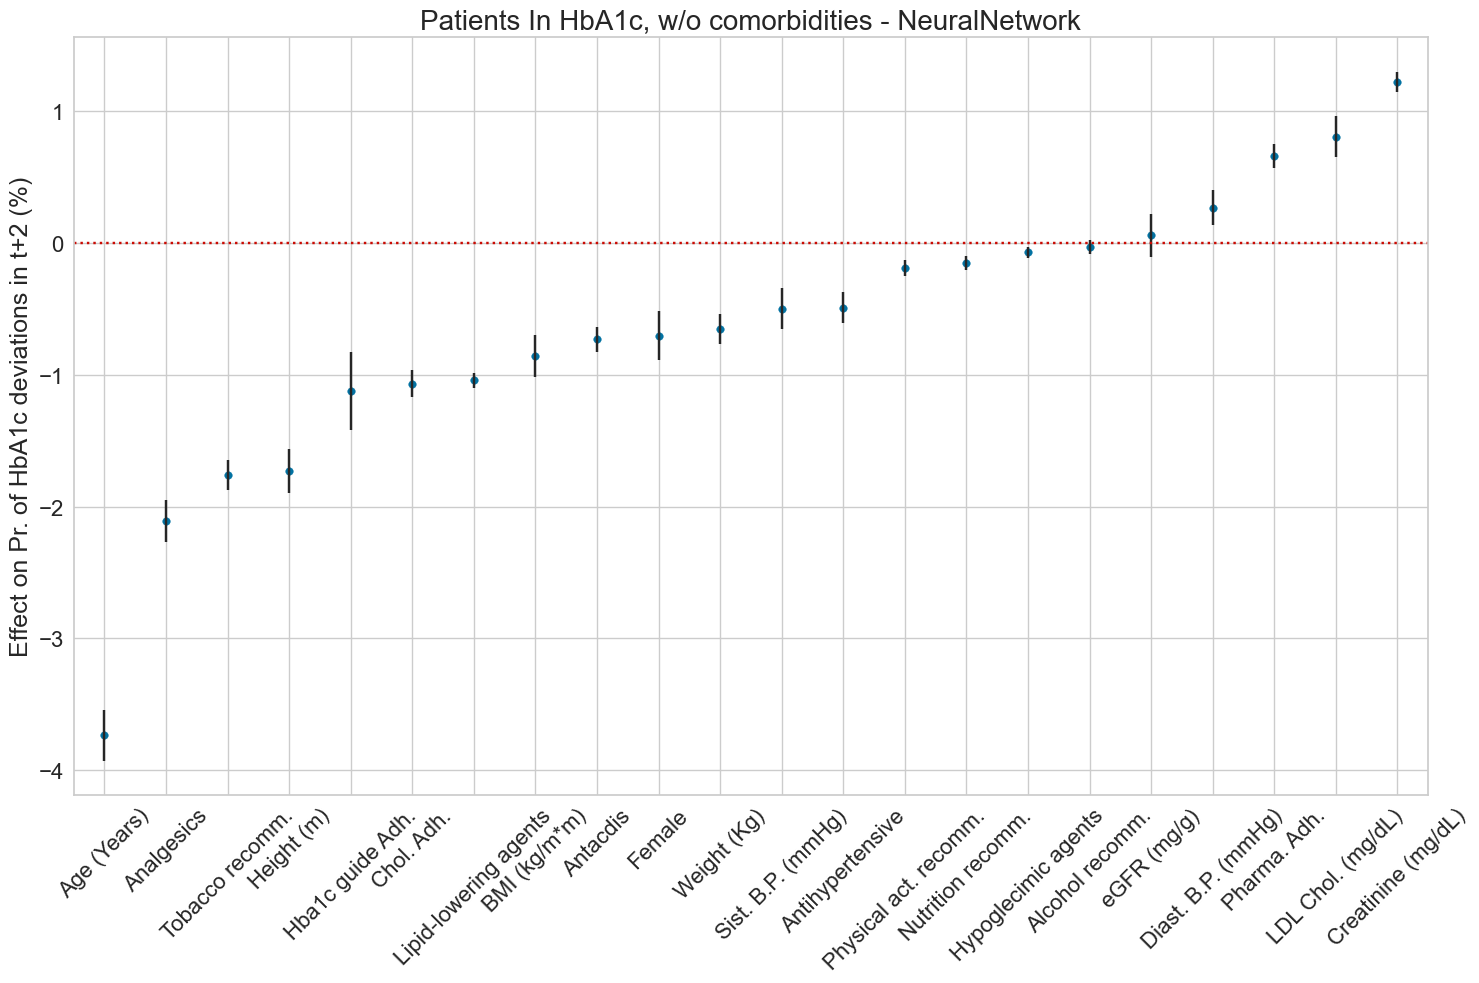

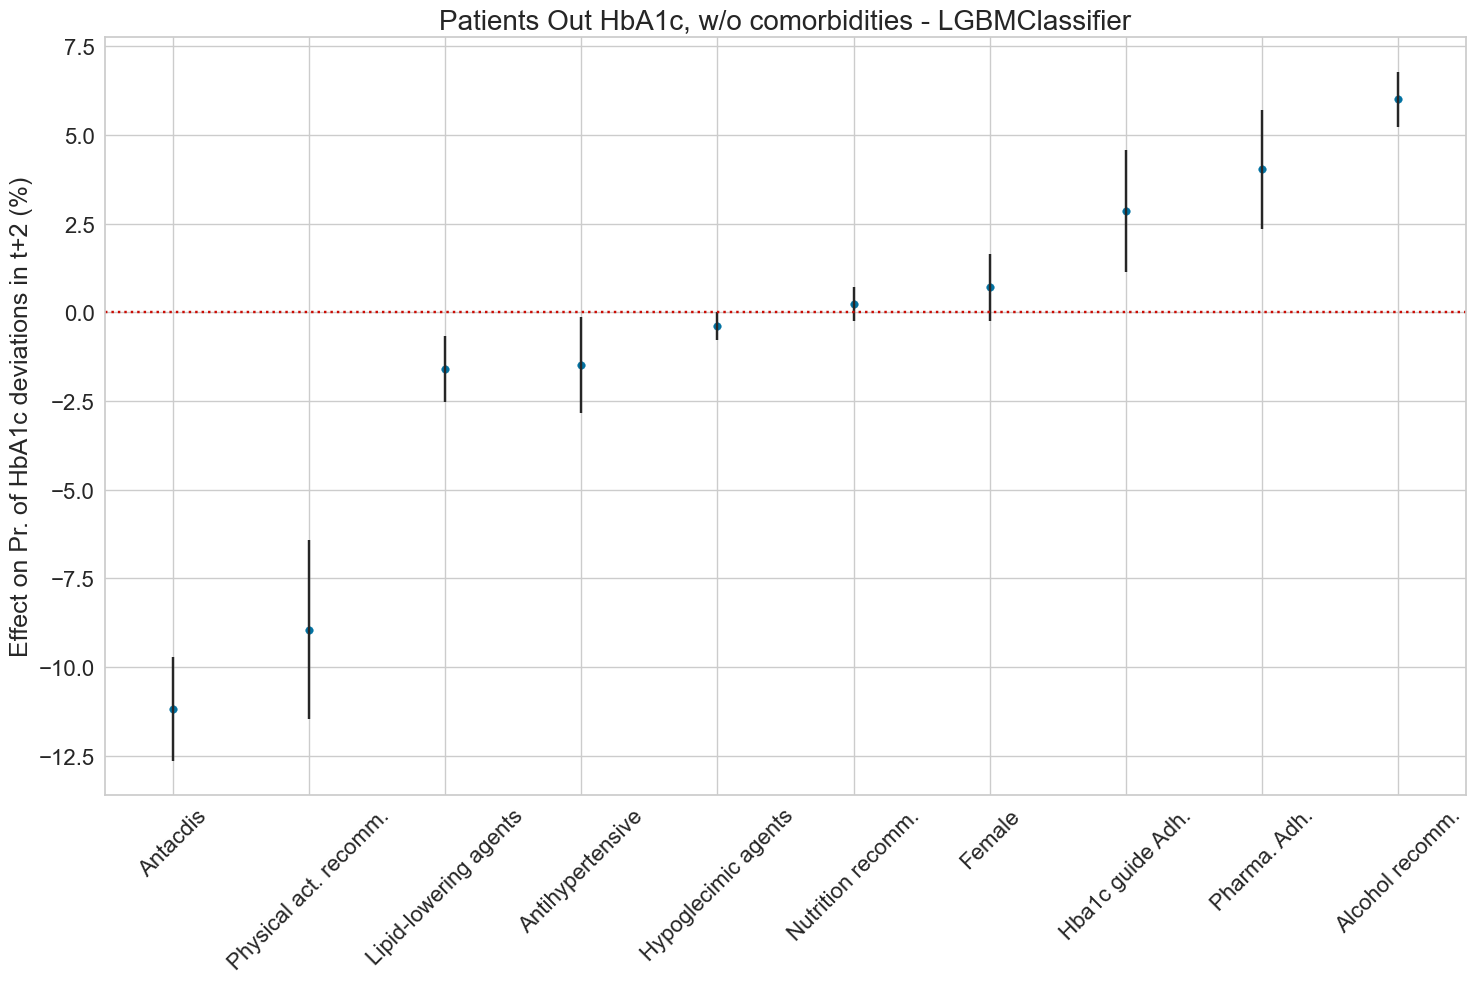

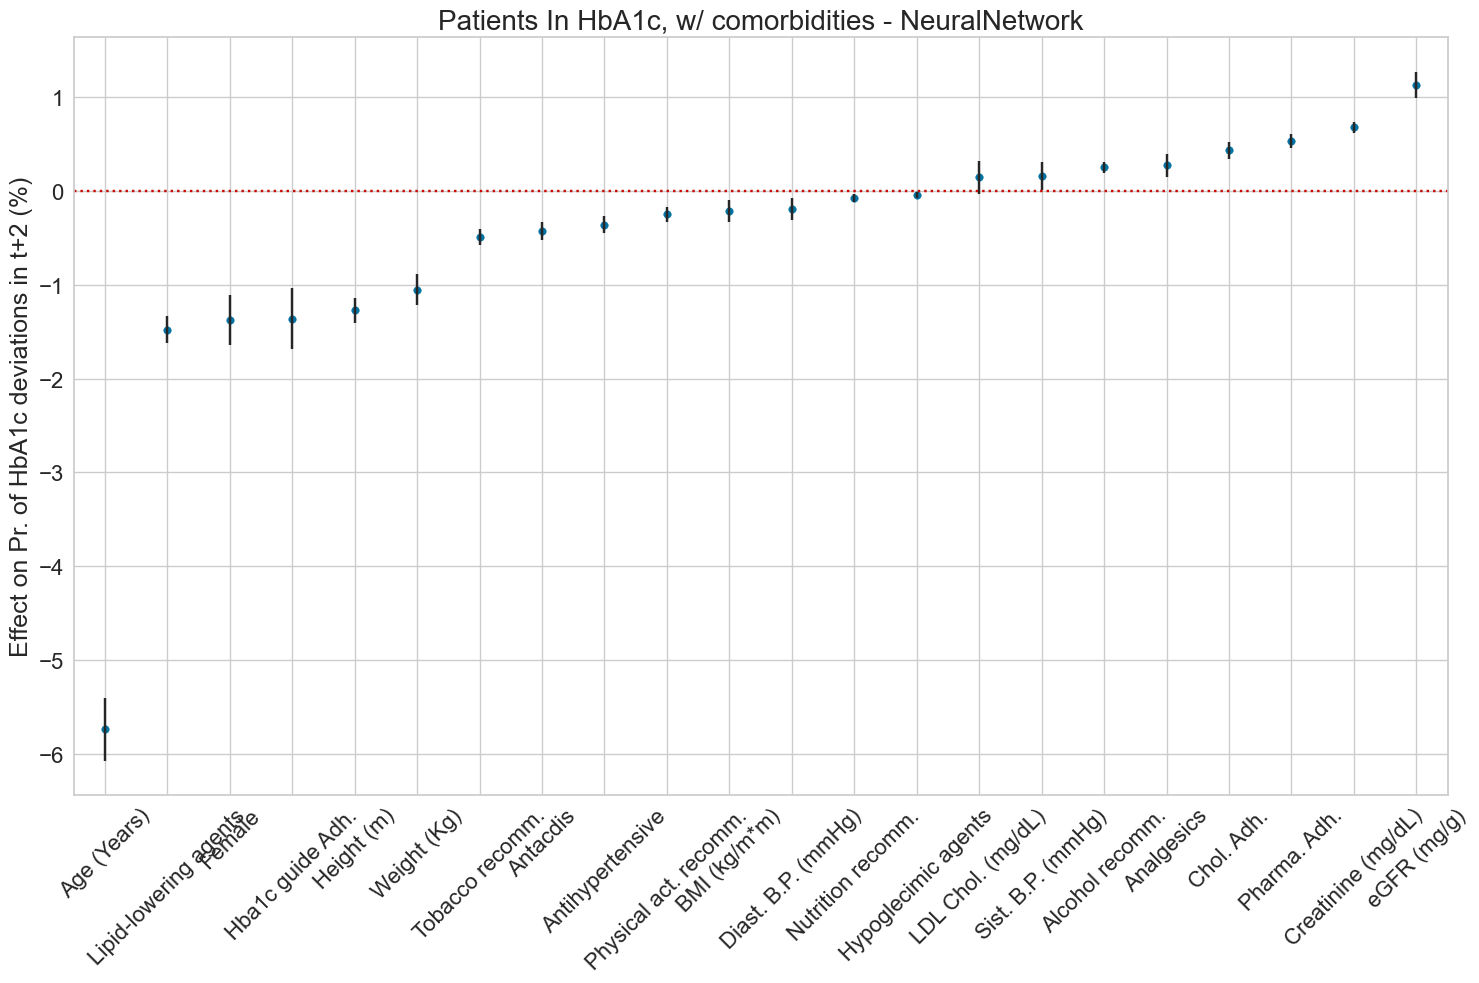

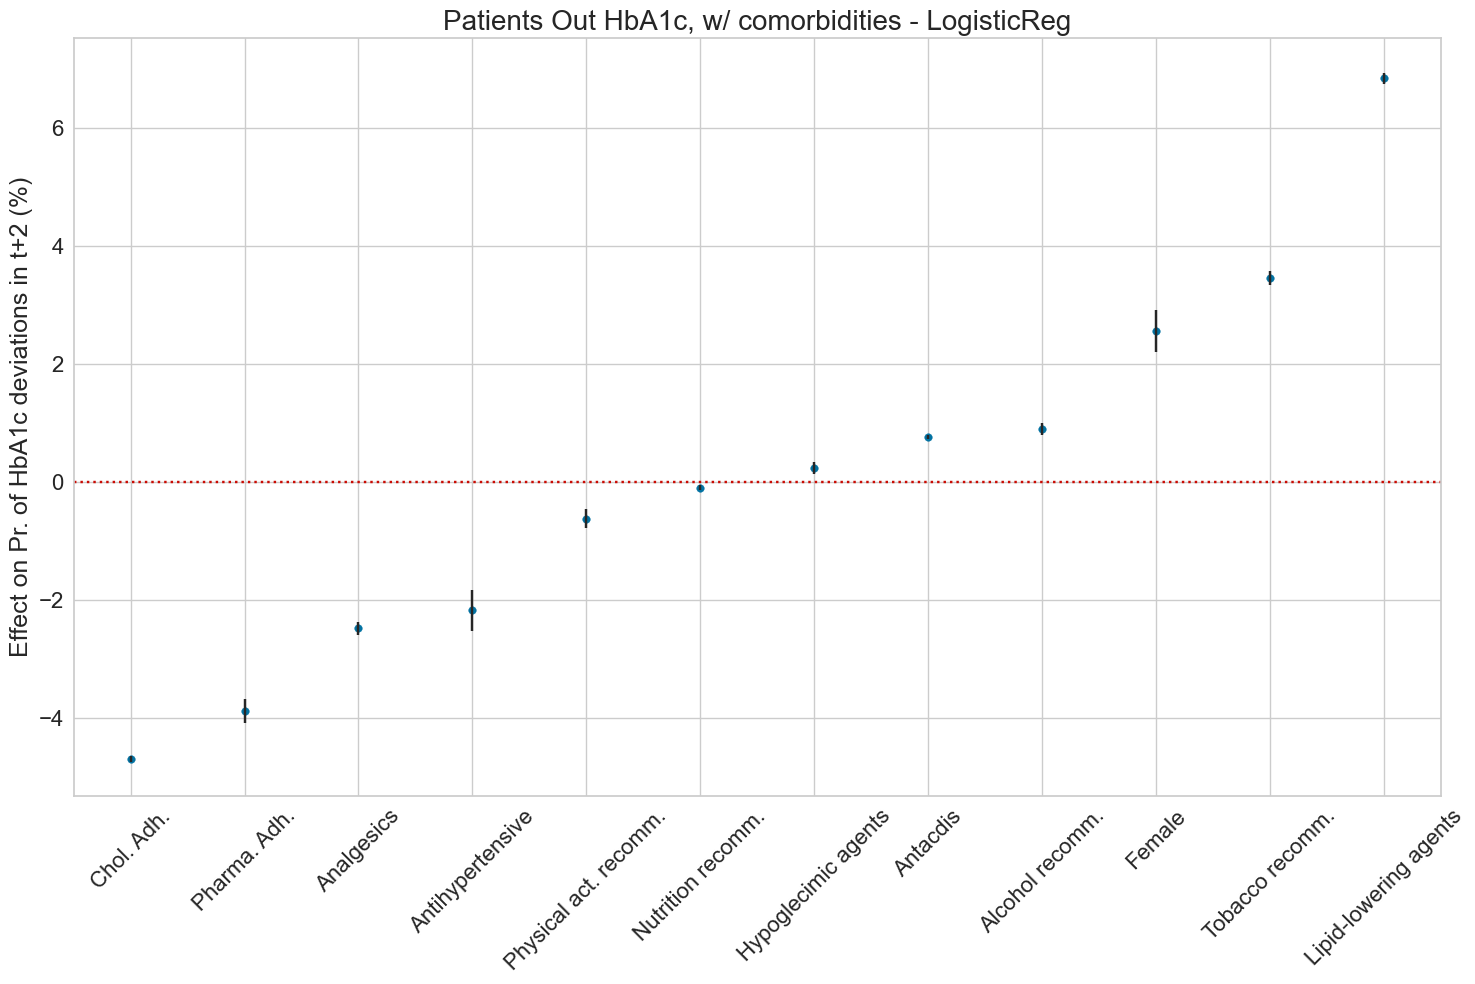

In [21]:
## Append de todos los resultados
all_results = pd.concat(all_margs, axis = 0)

## Iteraciones entre determinantes del modelo
for dep_var in ["comorbilidades", "fuera_metas"]:
    for tgt_year in [1, 2]:
        
        # Escogiendo el iterador de estadio base dependiendo de la variable a graficar
        if dep_var == "comorbilidades":
            base_iterator = [1, 2]
        elif dep_var == "fuera_metas":
            base_iterator = [1,2,3,4]
            
        for base_label in base_iterator:
            
            # Graficando
            coef_plotter(all_results = all_results, 
                         dep_var = dep_var, 
                         tgt_year = tgt_year,
                         base_label = base_label,
                         ci_stat = "ci")

#### Renombrando variables

In [12]:
# Computando estadísticos adicionales
all_results['iqr'] = all_results['p95']-all_results['p5']
all_results['iqr'] = all_results['p95']-all_results['p5']
all_results['se'] = all_results['std']/all_results['n']**0.5
all_results['lb'] = all_results['pctg']-1.98*all_results['se']
all_results['ub'] = all_results['pctg']+1.98*all_results['se']
all_results['ci'] = all_results['ub']-all_results['lb']

## Corrigiendo etiquetas y nombres de las variables
all_results.loc[:, 'Time Horizon'].replace(to_replace = [1, 2],
                                           value = ['t+1', 't+2'],
                                           inplace = True)

all_results.rename({'base_label' : 'Init. state'}, axis = 1, inplace = True)
all_results.loc[:, 'Init. state'].replace(to_replace = [1, 2, 3, 4],
                                          value = ['In HbA1C, w/o Comorb.', 'Out HbA1c, w/o Comorb.',
                                                   "In HbA1c, w/ Comorb.", "Out HbA1c, w/ Comorb."], 
                                          inplace = True)

all_results.loc[:, 'Dependent variable'].replace(to_replace = ["fuera_metas", "comorbilidades"],
                                                 value = ['HbA1c deviations', 'Comorbidities development'], 
                                                 inplace = True)

#### Tabla de efectos marginales para las comorbilidades

In [13]:
## Generando la tabla de efectos marginales
comorb_res = margeff_table(tgt_var = 'Comorbidities development', all_results = all_results)

## Seleccionando las variables a presentar
res_vars = ['Age (Years)', "Alcohol recomm.", "Analgesics", "Antacdis",
             "Antihypertensive", "Chol. Adh.", "Female", "Hba1c guide Adh.", "Hypoglecimic agents", 
             "Lipid-lowering agents", "Nutrition recomm.", "Pharma. Adh.", "Physical act. recomm.", 
             "Tobacco recomm.", "eGFR (mg/g)"]

## Cambiando 0's por missings 
comorb_res = comorb_res.loc[res_vars, :].replace({0 : np.nan}).reset_index()

## Corrigiendo algunos nombres de variables 
comorb_res.loc[:, 'Variable'].replace({'Antacdis' : 'Antacids', 
                                       'Hba1c guide Adh.' :" HbA1c guide Adh.", 
                                       "Hypoglecimic agents" : "Hypoglycemic agents"}, 
                                      inplace = True)

## Exportando la base de datos
comorb_res.set_index('Variable').apply(lambda x: pd.Series.round(x, 3)).to_csv(temp_path+'comorb_margeffs.csv', sep = ';')

#### Tabla de efectos marginales para la salida de metas

In [14]:
## Generando la tabla de efectos marginales
metas_res = margeff_table(tgt_var = 'HbA1c deviations', all_results = all_results) 

## Seleccionando las variables a presentar
metas_vars = ["Alcohol recomm.", "Analgesics", "Antacdis", "Antihypertensive", "Chol. Adh.", "Creatinine (mg/dL)", 
              "Hba1c guide Adh.", "Female", "Hba1c guide Adh.", "Hypoglecimic agents", "Lipid-lowering agents",
              "Nutrition recomm.", "Pharma. Adh.", "Physical act. recomm.", "Tobacco recomm.", "eGFR (mg/g)", "ERC_high"]

## Cambiando 0's por missings 
metas_res = metas_res.loc[res_vars, :].replace({0 : np.nan}).reset_index()

## Corrigiendo algunos nombres de variables 
metas_res.loc[:, 'Variable'].replace({'Antacdis' : 'Antacids', 
                                       'Hba1c guide Adh.' :" HbA1c guide Adh.", 
                                       "Hypoglecimic agents" : "Hypoglycemic agents"}, 
                                      inplace = True)

metas_res.set_index('Variable').apply(lambda x: pd.Series.round(x, 3)).to_csv(temp_path+'metas_margeffs.csv', sep = ';')